In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.cell_roi import RandomROISample
from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_DAT import AutoDAT
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.false_discovery_control import false_discovery_control
from lib.analysis.trace_metrics import TraceMetrics

###########################################
# Now we allow 3 barrels in a field of view to be analyzed
# in catalog, number of barrels is saved in Num_Barrels column
# The <slic>_<loc>_barrel_boundary.dat file is in ascending order of barrels, one
#   separate ROI for each barrel
###########################################

In [2]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
slice_type =   'coronal' #'sagittal' # 'merged' #
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"

if slice_type != 'merged':
    if slice_type == 'coronal':
        data_dir += "coronal-crossing/"
    else:
        data_dir += (slice_type + "/")

camera_program = 4

# annotation settings
skip_draw_annotations = True  # If True, don't draw any new annotations

# Movie maker settings
enable_photoZ_interact = True
initialize_photoZ = True

In [3]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()

In [249]:
def get_stim_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_electrode.dat"

def get_barrel_boundary_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_barrel_boundary.dat"

def get_L4_L5_boundary_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_L5_boundary.dat"

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['ROI',  'Value'])
    return data_arr

def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

crossing_directions = ["Lateral", "Medial"]
if slice_type == 'sagittal':
    crossing_directions = ["Rostral", "Caudal"]

stim_df = {
    'Date': [],
    "Slice_Loc": [],
    'stim_distance1': [], # distance to L4-L5 boundary
    'stim_distance2': [] # distance to neighboring barrel (in final CSV, this is 0 if home barrel)
}
already_drawn_slic_loc = {}

In [250]:
# First ask user to annotate some images with:
#       - Electrode loc 
#       - L4 - L5 boundary
#       - Barrel boundary that is being crossed
# Calculate:
#       - Distance from electrode to L4 boundary (distance1)
#       - Distance from electrode to neighboring barrel (distance2)
# This will be used to calculate distance from electrode to L4 boundary and from electrode to neighboring barrel

def parse_date(subdir):
    try:
        char_select = -len('dd-mm-yyyy')
        subdir = subdir.replace("\\", "/")
        date = subdir.split("/")[-1][char_select:]
        date = [int(x) for x in date.split("-")]
        date = "/".join([str(d) for d in date])
        return date
    except Exception as e:
        print(e, "could not process date.")
        return subdir

data_map = {}
for subdir, dirs, files in os.walk(data_dir):

    if 'notUsable' in subdir:
        continue
    if 'hidden' in subdir:
        continue
    if 'dic' in dirs and 'selected_zda' in dirs:
        print("\n", subdir)
        dic_dir = subdir + "/dic/"
        selected_zda_dir = subdir + "/selected_zda/"
        
        # optionally process date
        date = parse_date(subdir)

        # take selected zda and expand into separate subdir for each zda file
        print(os.listdir(selected_zda_dir))
        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):
                rec_id = zda_file.split('.')[0]
                print("\n", selected_zda_dir + "/" + zda_file)
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]

                if subdir not in data_map:
                    data_map[subdir] = {}
                if slic_id not in data_map[subdir]:
                    data_map[subdir][slic_id] = {}
                if loc_id not in data_map[subdir][slic_id]:
                    data_map[subdir][slic_id][loc_id] = {
                        'zda_files': []
                    }
                data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)

                annotate_id = date + "_" + str(slic_id) + "_" + str(loc_id)
                if skip_draw_annotations:
                    continue
                if annotate_id in already_drawn_slic_loc and already_drawn_slic_loc[annotate_id]:
                    print("Already annotated ", annotate_id, ", skipping.")
                    continue
                already_drawn_slic_loc[annotate_id] = True

                # read in 8-bit single TIF images to array, apply same cropping/binning
                image_data = {}
                cam_settings = CameraSettings().get_program_settings(camera_program)
                binning = int(2048 / 400) # if want size similar to RLI
                TIFLoader(dic_dir, 
                          cam_settings, 
                          binning, 
                          crop=False, 
                          flip_horiz=True).load_files(image_data, 
                                                      slice_target=slic_id)

                img_aligner = ImageAlign()

                for slic in image_data:
                    for loc in image_data[slic]:
                        if slic != slic_id or loc != loc_id:
                            continue
                        print(slic, loc)

                        # DICs
                        fluor = None
                        if 'f' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['f']
                        elif 'fe' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['fe']
                        # img = image_data[slic][loc]['i']

                        dic_electrode = None
                        if 'e' in image_data[slic][loc]:
                            dic_electrode = image_data[slic][loc]['e']
                        else:
                            dic_electrode = fluor

                        dic_electrode = np.array(dic_electrode, dtype=np.uint8)
                        orig_arr_shape = dic_electrode.shape

                        # ask user to select site of stim and layer/barrel borders
                        #       - Distance from electrode to L4 boundary (distance1)
                        #       - Distance from electrode to neighboring barrel (distance2)
                        if not skip_draw_annotations:
                            window_title = date + " " + rec_id

                            # ask user to select electrode
                            dic_electrode, electrode_coords = img_aligner.draw_electrode_on_image(
                                dic_electrode, 
                                window_title + " Electrode")
                            dic_electrode = np.array(dic_electrode)

                            # mark the electrode location into fluor image
                            x_el, y_el = electrode_coords['electrode']
                            for dx in range(-5, 5):
                                for dy in range(-5, 5):
                                    if x_el + dx >= 0 and x_el + dx < fluor.shape[1] and y_el + dy >= 0 and y_el + dy < fluor.shape[0]:
                                        fluor[int(y_el) + dy, int(x_el) + dx] = 0

                            # ask user to select L4 - L5 boundary
                            distance1_boundary, distance1_coords = img_aligner.draw_electrode_on_image(
                                fluor,
                                window_title + " Distance1 Boundary (L4 - L5 boundary)")
                            distance1_boundary = np.array(distance1_boundary)

                            # ask user to select barrel boundary
                            distance2_boundary, distance2_coords = img_aligner.draw_electrode_on_image(
                                fluor,
                                window_title + " Distance2 Boundary (Barrel boundary)")
                            distance2_boundary = np.array(distance2_boundary)
                            
                            # make 1 row of 2 subplots
                            fig, axes = plt.subplots(1, 3)
                            axes[0].imshow(dic_electrode, cmap='gray')
                            axes[1].imshow(fluor, cmap='gray')
                            
                            x_d1, y_d1 = distance1_coords['electrode']
                            x_d2, y_d2 = distance2_coords['electrode']

                            for ax in axes[:2]:
                                l1, = ax.plot(x_el, y_el, marker="*", color='red', label="Electrode")
                                l2, = ax.plot(x_d1, y_d1, marker="*", color='green', label="L4 - L5 boundary")
                                l3, = ax.plot(x_d2, y_d2, marker="*", color='blue', label="Barrel boundary")
                                ax.set_yticks([])
                                ax.set_xticks([])


                            axes[2].legend(handles=[l1, l2, l3],
                                           labels=["Electrode", "L4 - L5 boundary", "Barrel boundary"])
                            axes[2].axis('off')
                            plt.show()

                            # no need to transform the coordinates, just calculate distances and convert px -> microns
                            dic_um_per_px = 425 / fluor.shape[1]
                            distance1 = Line([x_el, y_el], [x_d1, y_d1]).get_length() * dic_um_per_px
                            distance2 = Line([x_el, y_el], [x_d2, y_d2]).get_length() * dic_um_per_px
                            print("Distance1 (L4 - L5 boundary):", distance1)
                            print("Distance2 (Barrel boundary):", distance2)

                            # append data to Dataframe to write to CSV

                            # turn date into 4-digit year
                            if len(date.split("/")[-1]) < len("20YY"):
                                date = "/".join(date.split("/")[:2] + ["20" + date.split("/")[-1]])
                            
                            stim_df["Date"].append(date)
                            stim_df["Slice_Loc"].append(str(slic) + "_" + str(loc))
                            stim_df["stim_distance1"].append(distance1)
                            stim_df["stim_distance2"].append(distance2)
                            
                            
stim_df = pd.DataFrame(stim_df)



 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24
['03_01_01.zda', '03_02_01.zda', '03_03_01.zda', '03_04_01.zda', '03_05_01.zda', '04_01_01.zda', '04_02_01.zda', '04_03_01.zda', '05_01_01.zda', '05_02_01.zda', '05_03_01.zda', '3_1_barrel_boundary.dat', '3_1_electrode.dat', '3_1_L5_boundary.dat', '3_2_barrel_boundary.dat', '3_2_electrode.dat', '3_2_L5_boundary.dat', '3_3_barrel_boundary.dat', '3_3_electrode.dat', '3_3_L5_boundary.dat', '3_4_barrel_boundary.dat', '3_4_electrode.dat', '3_4_L5_boundary.dat', '3_5_barrel_boundary.dat', '3_5_electrode.dat', '3_5_L5_boundary.dat', '3_barrel_rois.dat', '3_barrel_roisROIs-rand_0.dat', '3_barrel_roisROIs-rand_1.dat', '3_barrel_roisROIs-rand_2.dat', '3_barrel_roisROIs-stripe_0.dat', '3_barrel_roisROIs-stripe_1.dat', '3_barrel_roisROIs-stripe_2.dat', '4_1_barrel_boundary.dat', '4_1_electrode.dat', '4_1_L5_boundary.dat', '4_2_barrel_boundary.dat', '4_2_electrode.dat', '4_2_L5_boundary.dat', '4_3_barrel_boundary.dat

In [251]:
if skip_draw_annotations:
    # load from CSV
    stim_df = pd.read_csv(data_dir + slice_type + "_crossing_with_distances.csv")
else:
    # write df to CSV
    stim_df.to_csv(data_dir + slice_type + "_crossing_with_distances.csv", index=False)
stim_df

,Date,Slice_Loc,stim_distance1,stim_distance2
0,6/25/2024,3_1,187.693345,99.530659
1,6/25/2024,3_2,217.312644,81.268081
2,6/25/2024,3_3,181.773990,76.459356
3,6/25/2024,3_4,172.908802,155.375820
4,6/25/2024,3_5,171.891643,96.549476
5,6/25/2024,4_1,187.438544,115.948125
6,6/25/2024,4_2,213.735378,81.041035
7,6/25/2024,4_3,186.214667,64.847900
8,6/25/2024,5_1,112.445199,141.309565
9,6/25/2024,5_2,160.517183,134.227464


In [252]:
# go through the ZDA files and extract amp arrays 
# autoPhotoZ to save amplitude arrays for each measure window and 
# baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id):
    return subdir + "/" + "ampArray_" + slic_loc_id + ".dat"

for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    aPhz = AutoPhotoZ(data_dir=subdir)
    if enable_photoZ_interact:
        aPhz.select_MaxAmp_array()
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                print(zda_file)
                amp_array_filename = get_amp_array_filename(subdir, slic_loc_id)
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                    aPhz.save_background(filename=amp_array_filename)

                if 'amp_arrays' not in data_map[subdir][slic_id][loc_id]:
                    data_map[subdir][slic_id][loc_id]['amp_arrays'] = []
                    data_map[subdir][slic_id][loc_id]['roi_file'] = selected_zda_dir + str(slic_id) + "_barrel_rois.dat"

                data_map[subdir][slic_id][loc_id]['amp_arrays'].append(amp_array_filename)
                data_map[subdir][slic_id][loc_id]['roi_file'] = selected_zda_dir + str(slic_id) + "_barrel_rois.dat"


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//03_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//03_02_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//03_03_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//03_04_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//03_05_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//04_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//04_02_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//04_03_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//05_01_01.zda
C:/Users/jjudge3/Desktop/Dat

In [253]:
# use read_dat_arr_file to read in the amp arrays
# also read in the barrel ROIs (#_barrel_rois.dat) to know which pixels' amplitudes to analyze
def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr

final_df = {
    "Date": [],
    "Slice_Loc": [],
    "Neighbor_Barrel": [], 
    "Stim_Location": [],
    "Home_Barrel": [],
    "Home_Barrel_Amp": [],
    "Neighbor_Barrel_Amp": [],
    "Neighbor_Responding_Area_Fraction": [],
    'stim_distance1': [],
    'stim_distance2': [],
    'crossing_direction': [] # to caudal or to rostral
}
if slice_type == 'sagittal':
    final_df["Most_Caudal_Barrel"] = []
elif slice_type == 'coronal':
    final_df["Most_Medial_Barrel"] = []

# load catalog of metadata
catalog_df = pd.read_csv(data_dir + slice_type + "_catalog.csv")
show_plots = False

for subdir in data_map:
    date = parse_date(subdir)
    
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:

            roi_file = data_map[subdir][slic_id][loc_id]['roi_file']
            roi_list = rfr = ROIFileReader(roi_file).get_roi_list()  # list of ROIs as diode numbers

            for amp_arr_file in data_map[subdir][slic_id][loc_id]['amp_arrays']:
                print(amp_arr_file)

                amp_array = read_dat_arr_file(amp_arr_file)


                # get amp cutoff for this slice/loc from catalog_df
                slice_loc_id = str(slic_id) + "_" + str(loc_id)

                # convert mm/dd/yy to mm/dd/yyyy
                if len(date.split("/")[-1]) < len("yyyy"):
                    date = date.split("/")
                    date = date[0] + "/" + date[1] + "/20" + date[2]
                print(date, slice_loc_id)

                masked_amp_array = np.zeros(amp_array.shape)

                # convert diode to xy
                rois = [LaminarROI(roi).get_points() for roi in roi_list]

                slice_loc_df = catalog_df[(catalog_df['Slice_Loc'] == slice_loc_id) & 
                                          (catalog_df['Date'] == date)]

                # get home barrel index (1-indexed)
                home_barrel = slice_loc_df['Home_Barrel'].values[0]

                # calculate crossing direction
                if slice_type == 'sagittal':
                    most_medial_barrel = slice_loc_df['Most_Caudal_Barrel'].values[0]
                elif slice_type == 'coronal':
                    most_medial_barrel = slice_loc_df['Most_Medial_Barrel'].values[0]
                num_barrels = 2
                crossing_directions
                try:
                    num_barrels = slice_loc_df['Num_Barrels'].values[0]
                except:
                    pass
                for neighbor_barrel in range(1, num_barrels + 1):
                    if neighbor_barrel == home_barrel:
                        continue
                    crossing_direction = None
                    if num_barrels == 2:
                        if home_barrel == most_medial_barrel:
                            crossing_direction = crossing_directions[0]
                        else:
                            crossing_direction = crossing_directions[1]
                    elif num_barrels == 3:
                        # most medial barrel can only be 1 or 3, not 2
                        if most_medial_barrel == 1:
                            if home_barrel == 1:
                                crossing_direction = crossing_directions[0]
                            elif home_barrel == 3:
                                crossing_direction = crossing_directions[1]
                            elif home_barrel == 2:
                                # Then there may be measurements for neighbors in both medial and lateral directions
                                if neighbor_barrel == 1:
                                    crossing_direction = crossing_directions[1]
                                elif neighbor_barrel == 3:
                                    crossing_direction = crossing_directions[0]
                        if most_medial_barrel == 3:
                            if home_barrel == 3:
                                crossing_direction = crossing_directions[0]
                            elif home_barrel == 1:
                                crossing_direction = crossing_directions[1]
                            elif home_barrel == 2:
                                # Then there may be measurements for neighbors in both medial and lateral directions
                                if neighbor_barrel == 3:
                                    crossing_direction = crossing_directions[1]
                                elif neighbor_barrel == 1:
                                    crossing_direction = crossing_directions[0]
                        

                    # get average amplitude of home barrel
                    home_barrel_roi = rois[home_barrel - 1]
                    home_barrel_amp = np.mean([amp_array[y, x] for x, y in home_barrel_roi])

                    # get average amplitude of neighboring barrel
                    neighbor_barrel_roi = rois[neighbor_barrel - 1]
                    neighbor_barrel_amp = np.mean([amp_array[y, x] for x, y in neighbor_barrel_roi])

                    amp_cutoff = home_barrel_amp * 0.35

                    # mask out everything except the ROIs
                    for roi in rois:
                        for x, y in roi:
                            if amp_array[y, x] > amp_cutoff:
                                masked_amp_array[y, x] = amp_array[y, x]
                    
                    # display amp array
                    if show_plots:
                        plt.imshow(masked_amp_array, cmap='hot')
                        plt.title(date + " " + slice_loc_id + " Amp cutoff: " + str(amp_cutoff)[:4])
                        plt.show()

                    # calculate barrel ROI responding area fraction of neighbor barrel
                    resp_area = 0
                    for x, y in neighbor_barrel_roi:
                        if masked_amp_array[y, x] > amp_cutoff:
                            resp_area += 1
                    resp_area = resp_area / len(neighbor_barrel_roi)

                    # get stim distances from stim_df
                    slice_loc_stim_df = stim_df[(stim_df['Date'] == date) &
                                                (stim_df['Slice_Loc'] == slice_loc_id)]

                    # append to final_df
                    final_df["Date"].append(date)
                    final_df["Slice_Loc"].append(slice_loc_id)
                    if slice_type == 'sagittal':
                        final_df["Most_Caudal_Barrel"].append(most_medial_barrel)
                    elif slice_type == 'coronal':    
                        final_df["Most_Medial_Barrel"].append(most_medial_barrel)
                    final_df["Stim_Location"].append(slice_loc_df['Stim_Location'].values[0])
                    final_df["Home_Barrel"].append(home_barrel)
                    final_df["Neighbor_Barrel"].append(neighbor_barrel)
                    final_df["Home_Barrel_Amp"].append(home_barrel_amp)
                    final_df["Neighbor_Barrel_Amp"].append(neighbor_barrel_amp)
                    final_df["Neighbor_Responding_Area_Fraction"].append(resp_area)
                    final_df['stim_distance1'].append(slice_loc_stim_df['stim_distance1'].values[0])
                    final_df['stim_distance2'].append(slice_loc_stim_df['stim_distance2'].values[0])
                    final_df['crossing_direction'].append(crossing_direction)

# create final_df Dataframe
final_df = pd.DataFrame(final_df)
final_df

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/ampArray_3_1.dat
6/25/2024 3_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/ampArray_3_2.dat
6/25/2024 3_2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/ampArray_3_3.dat
6/25/2024 3_3
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/ampArray_3_4.dat
6/25/2024 3_4
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/ampArray_3_5.dat
6/25/2024 3_5
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/ampArray_4_1.dat
6/25/2024 4_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/ampArray_4_2.dat
6/25/2024 4_2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/ampArray_4_3.dat
6/25/2024 4_3
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/ampArray_5_1.dat
6/25/2

,Date,Slice_Loc,Neighbor_Barrel,Stim_Location,Home_Barrel,Home_Barrel_Amp,Neighbor_Barrel_Amp,Neighbor_Responding_Area_Fraction,stim_distance1,stim_distance2,crossing_direction,Most_Medial_Barrel
0,6/25/2024,3_1,1,L2/3,2,1.366791,0.681601,0.906780,187.693345,99.530659,Medial,1
1,6/25/2024,3_1,3,L2/3,2,1.366791,0.625438,0.849153,187.693345,99.530659,Lateral,1
2,6/25/2024,3_2,1,L2/3,3,0.998281,0.340719,0.419492,217.312644,81.268081,Medial,1
3,6/25/2024,3_2,2,L2/3,3,0.998281,0.989722,1.000000,217.312644,81.268081,Medial,1
4,6/25/2024,3_3,1,L2/3,3,1.298151,0.439669,0.413136,181.773990,76.459356,Medial,1
5,6/25/2024,3_3,2,L2/3,3,1.298151,1.172727,1.000000,181.773990,76.459356,Medial,1
6,6/25/2024,3_4,1,L2/3,3,1.164250,0.477035,0.658898,172.908802,155.375820,Medial,1
7,6/25/2024,3_4,2,L2/3,3,1.164250,0.693970,0.982114,172.908802,155.375820,Medial,1
8,6/25/2024,3_5,1,L2/3,2,1.421796,0.683275,0.881356,171.891643,96.549476,Medial,1
9,6/25/2024,3_5,3,L2/3,2,1.421796,0.680064,0.869492,171.891643,96.549476,Lateral,1


In [254]:
# save to CSV
final_df.to_csv(data_dir + slice_type + "_crossing_final.csv", index=False)

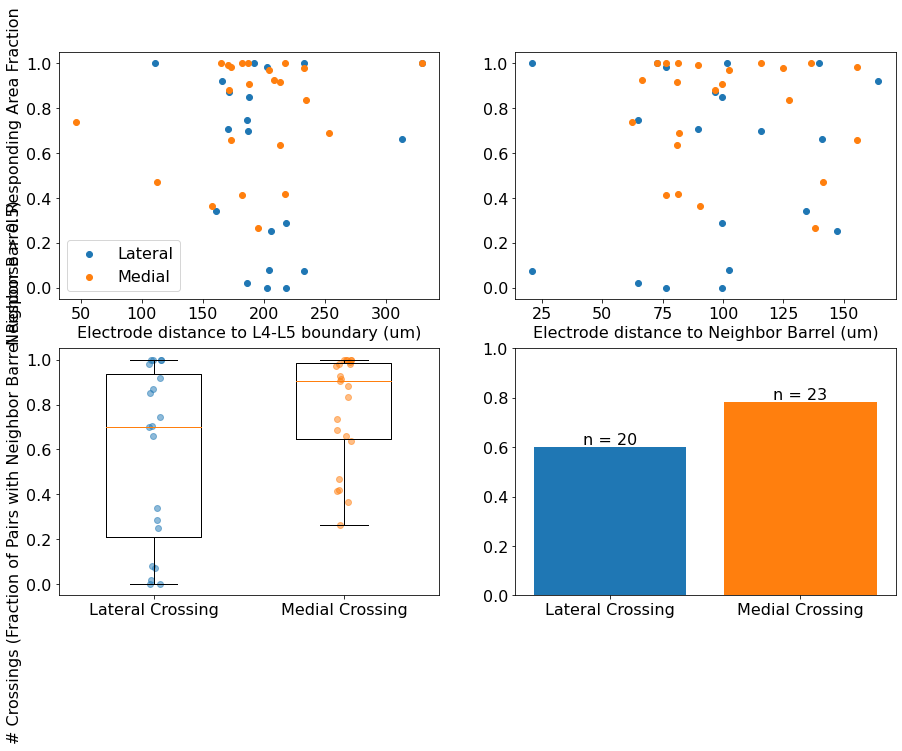

In [255]:
# plot distributions of responding area fraction for each crossing direction as scatter plots

# scatter plot of responding area fraction vs distance to L4-L5 boundary
# and vs distance to barrel boundary

handles = []
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for direction in crossing_directions:
    df = final_df[final_df['crossing_direction'] == direction]
    l1 = ax[0][0].scatter(df['stim_distance1'], df['Neighbor_Responding_Area_Fraction'], label=direction + " Crossing")
    l2 = ax[0][1].scatter(df['stim_distance2'], df['Neighbor_Responding_Area_Fraction'], label=direction + " Crossing")
    handles .append(l1)

ax[0][0].set_ylabel("Neighbor Barrel Responding Area Fraction")
ax[0][0].set_xlabel("Electrode distance to L4-L5 boundary (um)")
ax[0][1].set_xlabel("Electrode distance to Neighbor Barrel (um)")
ax[0][0].legend(handles, crossing_directions)

# in ax[1][0], plot responding area fraction distribution for each crossing direction
for i, direction in enumerate(crossing_directions):
    df = final_df[final_df['crossing_direction'] == direction]
    if len(df) == 0:
        continue
    x_jitter = [i + random.uniform(-0.04, 0.04) for _ in range(len(df))]
    l1 = ax[1][0].scatter(x_jitter, df['Neighbor_Responding_Area_Fraction'], alpha=0.5)
    
    

    # insert box and whisker plot for each crossing direction in ax[1][0]
    ax[1][0].boxplot([df['Neighbor_Responding_Area_Fraction']], positions=[i], widths=0.5)

    # in ax[1][1], plot # crossings (responding area > 0.5) as bar graph for each crossing direction
    n_crossings = len(df[df['Neighbor_Responding_Area_Fraction'] > 0.5]) / len(df)
    ax[1][1].bar(i, n_crossings)
    ax[1][1].set_xticks([0, 1])
    ax[1][1].set_xlim(-0.5, 1.5)
    ax[1][1].set_ylim(0, 1)
    # annotate bar graph with number of pairs observed
    ax[1][1].text(i, n_crossings, "n = " + str(len(df)), ha='center', va='bottom')

ax[1][0].set_xticks([0, 1])
ax[1][0].set_xlim(-0.5, 1.5)
ax[1][1].set_xticklabels(["Lateral Crossing", "Medial Crossing"])
ax[1][0].set_xticklabels(["Lateral Crossing", "Medial Crossing"])
ax[1][0].set_ylabel("Neighbor Barrel Responding Area Fraction")
ax[1][0].set_ylabel("# Crossings (Fraction of Pairs with Neighbor Barrel Response > 0.5)")

plt.show()

In [256]:
# now generate either random barrel samples or striped barrel ROIs to extract latency
# create random ROI samples of 1 pixel, or stripes of 5 pixel width. Stripes parallel to barrel axis
# Generate ROI files of specified sizes
roi_type = "stripes"  # set to "stripes" or "random"

lock_roi = True  # set to True to lock in ROIs, as safeguard to avoid overwriting

roi_sampler = RandomROISample(1)
data_file_map = {}
distance_map = {}
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if '_barrel_rois.dat' in file:

            # load barrel file (lists of lists of diode numbers)
            barrel_rois = ROIFileReader(subdir + '/' + file).get_roi_list()

            # convert from diode to pixel
            barrel_rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in barrel_rois]
            
            
            brc = Barrel_ROI_Creator()
            new_rois = None
            if roi_type == "stripes":

                # parse slic from filename
                slic_id = int(file.split('_barrel_rois')[0][-1])
                # choose any loc_id
                loc_id = None
                for f in files:
                    if '_barrel_boundary.dat' in f:
                        slic_id_2 = int(f.split('_barrel_boundary')[0][-3])
                        if slic_id == slic_id_2:
                            loc_id = int(f.split('_barrel_boundary')[0][-1])
                            break

                if loc_id is None:
                    print("Could not find loc_id for slic", slic_id, "for file", file)
                    continue

                print("Using slic", slic_id, "loc", loc_id, "for file", file)

                # open electrode location file and get electrode location
                stim_file = get_stim_filename(subdir + "/", slic_id, loc_id)
                stim_point = ROIFileReader(stim_file).get_roi_list()
                stim_point = LaminarROI(stim_point[0], input_diode_numbers=True).get_points()[0]

                # and get barrel boundary location
                barrel_boundary_file = get_barrel_boundary_filename(subdir + "/", slic_id, loc_id)
                barrel_boundary = ROIFileReader(barrel_boundary_file).get_roi_list()
                barrel_boundary = LaminarROI(barrel_boundary[0], input_diode_numbers=True).get_points()[0]
                
                barrel_axis = Line(stim_point, barrel_boundary)
                new_rois = brc.get_striped_rois(barrel_rois, barrel_axis)  # default: 5 px per stripe
                
                # convert pixels to diode numbers
                roi_cr = ROICreator(None)
                for k in new_rois:
                    for b_idx in range(len(new_rois[k])):
                        new_rois[k][b_idx] = [roi_cr.convert_point_to_diode_number(px) for px in new_rois[k][b_idx]]
                
            elif roi_type == "random" and not lock_roi:
                new_rois = brc.get_rand_rois(barrel_rois)  # default: 1 px per ROI, 100 ROIs per barrel

                # convert pixels to diode numbers
                roi_cr = ROICreator(None)
                for k in new_rois:
                    new_rois[k] = [[roi_cr.convert_point_to_diode_number(px)] for px in new_rois[k]]

            # write each new ROI to a separate file
            rfw = ROIFileWriter()
            selected_zda_dir = subdir 
            subdir_shortened = subdir.split('\\selected_zda')[0]
            if subdir_shortened not in data_file_map:
                data_file_map[subdir_shortened] = {}
            data_file_map[subdir_shortened][file] = []
            for barrel_idx in new_rois:
                roi_file = brc.get_rand_roi_filename(selected_zda_dir, barrel_idx, file)
                if roi_type == "stripes":
                    roi_file = brc.get_stripe_roi_filename(selected_zda_dir, barrel_idx, file)
                if not lock_roi:
                    rfw.write_regions_to_dat(roi_file, new_rois[barrel_idx])
                    print("Wrote", roi_file)
                data_file_map[subdir_shortened][file].append(roi_file)

Using slic 3 loc 1 for file 3_barrel_rois.dat
Using slic 4 loc 1 for file 4_barrel_rois.dat
Using slic 5 loc 1 for file 5_barrel_rois.dat
Using slic 1 loc 1 for file 1_barrel_rois.dat
Using slic 2 loc 1 for file 2_barrel_rois.dat
Using slic 6 loc 1 for file 6_barrel_rois.dat
Using slic 1 loc 1 for file 1_barrel_rois.dat
Using slic 2 loc 1 for file 2_barrel_rois.dat
Using slic 3 loc 1 for file 3_barrel_rois.dat
Using slic 2 loc 2 for file 2_barrel_rois.dat


In [257]:
# now load these ROI files into PhotoZ and extract latency and halfwidth dat files
# go through the ZDA files and extract amp arrays 

if enable_photoZ_interact:
    pa.alert("Set measure window width to > 70 for half-width measurement.")
for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    if enable_photoZ_interact:
        aPhz = AutoPhotoZ(data_dir=subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            roi_file = data_map[subdir][slic_id][loc_id]['roi_file'].split("/")[-1]
            roi_barrel_files = data_file_map[subdir][roi_file]  # these are the random or slice ROIs

            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                print(zda_file)
                if not os.path.exists(zda_file):
                    print("ZDA file does not exist, skipping.")
                    continue
                
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)

                for i_barrel, barrel_roi_file in enumerate(roi_barrel_files):

                    if enable_photoZ_interact:
                        aPhz.select_roi_tab()
                        aPhz.open_roi_file(barrel_roi_file)
                        print("Opened ROI file", barrel_roi_file)
                        
                    # save half-width values from PhotoZ
                    hw_filename = subdir + "/" + "hw_" + slic_loc_id + "_barrel_" + roi_type + str(i_barrel+1) + ".dat" 
                    if enable_photoZ_interact:
                        pass #aPhz.select_half_width_trace_value()
                        #aPhz.save_trace_values(hw_filename)

                    # save amp values from PhotoZ
                    amp_filename = subdir + "/" + "amp_" + slic_loc_id + "_barrel_" + roi_type + str(i_barrel+1) + ".dat" 
                    if enable_photoZ_interact:
                        pass #aPhz.select_maxamp_trace_value()
                        #aPhz.save_trace_values(amp_filename)
                        
                    # save latency values from PhotoZ
                    lat_filename = subdir + "/" + "lat_" + slic_loc_id + "_barrel_" + roi_type + str(i_barrel+1) + ".dat" 
                    if enable_photoZ_interact:
                        pass
                        #aPhz.select_latency_trace_value()
                        #aPhz.save_trace_values(lat_filename)

                    trace_filename = subdir + "/" + "trace_" + slic_loc_id + "_barrel_" + roi_type + str(i_barrel+1) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.save_current_traces(trace_filename, go_to_tab=True)

                    if i_barrel+1 not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][i_barrel+1] = {}
                    data_map[subdir][slic_id][loc_id][i_barrel+1] = {'amp': amp_filename,
                                                                       'hw': hw_filename,
                                                                       'lat': lat_filename,
                                                                       'trace': trace_filename}
                    print(data_map[subdir][slic_id][loc_id])

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//03_01_01.zda
{'zda_files': ['C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda//03_01_01.zda'], 'amp_arrays': ['C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/ampArray_3_1.dat'], 'roi_file': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/selected_zda/3_barrel_rois.dat', 1: {'amp': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/amp_3_1_barrel_stripes1.dat', 'hw': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/hw_3_1_barrel_stripes1.dat', 'lat': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/lat_3_1_barrel_stripes1.dat', 'trace': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-25-24/trace_3_1_barrel_stripes1.dat'}}
{'zda_files': ['C:/Users/jjudge3/Deskt

In [258]:
# load in the new rois and calculate distance from ROI to electrode

amp_dfs = []
for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    date = parse_date(subdir)
    if enable_photoZ_interact:
        aPhz = AutoPhotoZ(data_dir=subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            # we also need stim point for this slice/loc
            stim_file = get_stim_filename(selected_zda_dir, slic_id, loc_id)
            stim_point = ROIFileReader(stim_file).get_roi_list()
            stim_point = LaminarROI(stim_point[0], input_diode_numbers=True).get_points()[0]

            # and get barrel boundary location
            barrel_boundary_file = get_barrel_boundary_filename(selected_zda_dir, slic_id, loc_id)
            barrel_boundary = ROIFileReader(barrel_boundary_file).get_roi_list()
            barrel_boundary = LaminarROI(barrel_boundary[0], input_diode_numbers=True).get_points()[0]

            # and get L4-L5 boundary location
            L5_boundary_file = get_L4_L5_boundary_filename(selected_zda_dir, slic_id, loc_id)
            L5_boundary = ROIFileReader(L5_boundary_file).get_roi_list()
            L5_boundary = LaminarROI(L5_boundary[0], input_diode_numbers=True).get_points()[0]

            # axis of barrel boundary to electrode
            barrel_axis = Line(stim_point, barrel_boundary)
            l5_axis = Line(stim_point, L5_boundary)

            roi_file = data_map[subdir][slic_id][loc_id]['roi_file'].split("/")[-1]
            roi_barrel_files = data_file_map[subdir][roi_file]

            for i_barrel, barrel_roi_file in enumerate(roi_barrel_files):
                roi_list = ROIFileReader(barrel_roi_file).get_roi_list()
                # convert from diode to pixel
                roi_list = [LaminarROI(roi, input_diode_numbers=True).get_points()
                            for roi in roi_list]
                
                # for each ROI, calculate distance to electrode
                # all ROIs are single-pixel
                
                distances = [v for v in 
                             [Line(stim_point, roi[0]).get_length() 
                             if len(roi) > 0 
                             else None
                               for roi in roi_list]
                               if v is not None]

                # also calculate the distance from the barrel boundary along the electrode-barrel line
                distances_along_axis = [v for v in 
                                         [barrel_axis.get_displacement_along_segment(barrel_boundary, roi[0]) 
                                        if len(roi) > 0 
                                        else None
                                        for roi in roi_list]
                                        if v is not None]
                
                distances_to_l5 = [v for v in 
                                   [l5_axis.get_displacement_along_segment(stim_point, roi[0])
                                        if len(roi) > 0 
                                        else None
                                    for roi in roi_list]
                                    if v is not None]

                # load the trace, amp, hw, and lat files for this barrel
                trace_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['trace']
                amp_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['amp']
                hw_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['hw']
                lat_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['lat']

                try:
                    trace = read_traces_file(trace_file)
                    amp = read_dat_trace_file(amp_file)
                    hw = read_dat_trace_file(hw_file)
                    lat = read_dat_trace_file(lat_file)
                except Exception as e:
                    print(e)
                    continue

                # calculate time to max amplitude in measure window from trace, using interpolation of 3 points
                measure_window = [96, 150]
                tm = TraceMetrics(trace)
                max_amp_times = tm.get_max_amp_times(measure_window=measure_window)
                
                # get crossing direction, stim location, and electrode distances from final_df
                # convert mm/dd/yy to mm/dd/yyyy
                
                if len(date.split("/")[-1]) < len("yyyy"):
                    date = date.split("/")
                    date = date[0] + "/" + date[1] + "/20" + date[2]
                slice_loc_df = final_df[(final_df['Date'] == date) &
                                        (final_df['Slice_Loc'] == slic_loc_id)]
                crossing_direction = slice_loc_df['crossing_direction'].values[0]
                stim_location = slice_loc_df['Stim_Location'].values[0]
                stim_distance1 = slice_loc_df['stim_distance1'].values[0]
                stim_distance2 = slice_loc_df['stim_distance2'].values[0]
                home_barrel = slice_loc_df['Home_Barrel'].values[0]
                neighbor_barrel = slice_loc_df['Neighbor_Barrel'].values[0]

                amp = amp.join(hw, rsuffix='_hw')
                amp = amp.join(lat, rsuffix='_lat')
                amp.insert(4, 'Distance', distances)
                amp.insert(4, 'Distance_Along_Barrel_Axis', distances_along_axis)
                amp.insert(4, 'Distance_To_L5', distances_to_l5)
                amp.insert(5, 'Barrel', [i_barrel+1 for _ in range(len(amp['ROI']))])
                amp.insert(6, 'Crossing_Direction', [crossing_direction for _ in range(len(amp['ROI']))])
                amp.insert(7, 'Stim_Location', [stim_location for _ in range(len(amp['ROI']))])
                amp.insert(8, 'Stim_Distance1', [stim_distance1 for _ in range(len(amp['ROI']))])
                amp.insert(9, 'Stim_Distance2', [stim_distance2 for _ in range(len(amp['ROI']))])
                amp.insert(10, 'Date', [date for _ in range(len(amp['ROI']))])
                amp.insert(11, 'Max_Amp_Time', max_amp_times)
                amp.insert(11, 'Slice_Loc', [slic_loc_id for _ in range(len(amp['ROI']))])
                amp.insert(12, 'Home_Barrel', [home_barrel for _ in range(len(amp['ROI']))])
                amp.insert(12, 'Neighbor_Barrel', [neighbor_barrel for _ in range(len(amp['ROI']))])
                amp.insert(13, 'Slice', [slic_id for _ in range(len(amp['ROI']))])
                amp.insert(14, 'Loc', [loc_id for _ in range(len(amp['ROI']))])
                amp.insert(15, 'Is_Home_Barrel', [1 if i_barrel+1 == home_barrel else 0 for _ in range(len(amp['ROI']))])
                if slice_type == 'sagittal':
                    amp.insert(16, "Is_Rostral_Crossing", [1 if crossing_direction == "Rostral" else 0 for _ in range(len(amp['ROI']))])
                elif slice_type == 'coronal':    
                    amp.insert(16, "Is_Lateral_Crossing", [1 if crossing_direction == "Lateral" else 0 for _ in range(len(amp['ROI']))])
                amp.insert(17, "Animal", [date for _ in range(len(amp['ROI']))])
                amp.insert(18, "Litter", [11 if date in ['6/4/2024', '6/3/2024'] else 10 for _ in range(len(amp['ROI']))])

                amp = amp[pd.to_numeric(amp.Value, errors='coerce').notnull()]
                amp['Value'] /= 1000
                amp_dfs.append(amp)
        
pixel_df = pd.concat(amp_dfs)
pixel_df = pixel_df[['Date', 'Slice_Loc', 'ROI', 'Value', 'Value_hw', 'Max_Amp_Time',
                                 'Value_lat', 'Distance', 'Distance_Along_Barrel_Axis', 
                                 'Barrel', 'Home_Barrel', 'Distance_To_L5', 'Neighbor_Barrel',
                                    'Crossing_Direction', 'Stim_Location', 'Stim_Distance1', 'Stim_Distance2',
                                    'Slice', 'Loc', 'Is_Home_Barrel', 'Is_' + crossing_directions[0] + '_Crossing', 'Animal', 'Litter'
                                 ]]

pixel_df

,Date,Slice_Loc,ROI,Value,Value_hw,Max_Amp_Time,Value_lat,Distance,Distance_Along_Barrel_Axis,Barrel,...,Crossing_Direction,Stim_Location,Stim_Distance1,Stim_Distance2,Slice,Loc,Is_Home_Barrel,Is_Lateral_Crossing,Animal,Litter
0,6/25/2024,3_1,1,0.000793,12.2953,53.250454,51.8526,28.460499,4.540766,1,...,Medial,L2/3,187.693345,99.530659,3,1,0,0,6/25/2024,10
1,6/25/2024,3_1,2,0.000645,17.7750,59.247859,51.8450,32.202484,9.263163,1,...,Medial,L2/3,187.693345,99.530659,3,1,0,0,6/25/2024,10
2,6/25/2024,3_1,3,0.000545,17.3931,54.749019,52.1832,38.626416,14.666674,1,...,Medial,L2/3,187.693345,99.530659,3,1,0,0,6/25/2024,10
3,6/25/2024,3_1,4,0.000469,17.1436,59.751010,52.5067,44.598206,19.933963,1,...,Medial,L2/3,187.693345,99.530659,3,1,0,0,6/25/2024,10
4,6/25/2024,3_1,5,0.000485,19.7282,61.246033,53.1831,46.486557,21.477824,1,...,Medial,L2/3,187.693345,99.530659,3,1,0,0,6/25/2024,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,7/3/2024,2_3,4,0.000300,13.0350,54.248887,52.1573,49.979996,16.306453,2,...,Medial,L2/3,232.826295,125.056742,2,3,0,0,7/3/2024,10
4,7/3/2024,2_3,5,0.000289,20.5443,55.749633,52.5094,50.990195,20.132548,2,...,Medial,L2/3,232.826295,125.056742,2,3,0,0,7/3/2024,10
5,7/3/2024,2_3,6,0.000315,33.7777,55.746119,52.9914,55.072679,25.461752,2,...,Medial,L2/3,232.826295,125.056742,2,3,0,0,7/3/2024,10
6,7/3/2024,2_3,7,0.000325,33.7657,55.748290,52.8719,58.830264,29.925530,2,...,Medial,L2/3,232.826295,125.056742,2,3,0,0,7/3/2024,10


In [259]:
pixel_df.to_csv(data_dir + slice_type +"_crossing_final_by_" + roi_type +  ".csv", index=False)

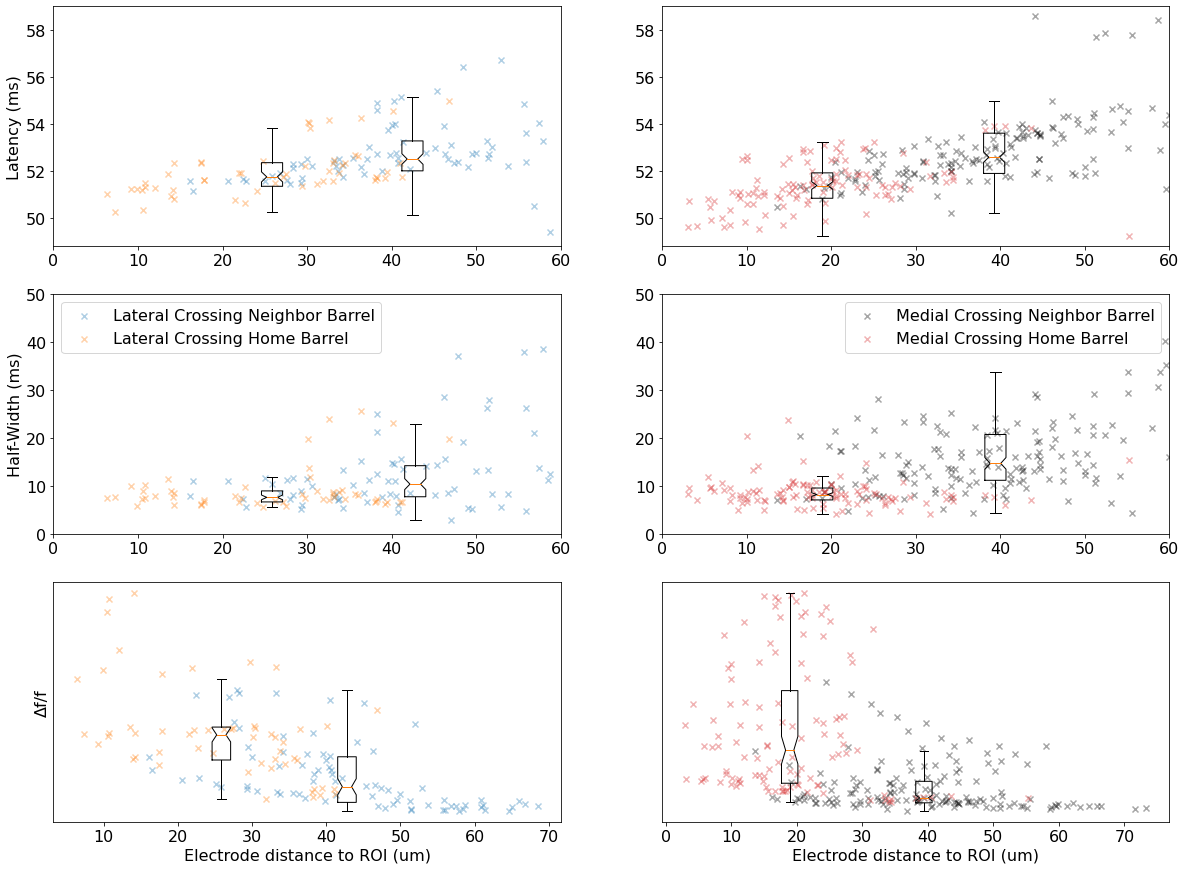

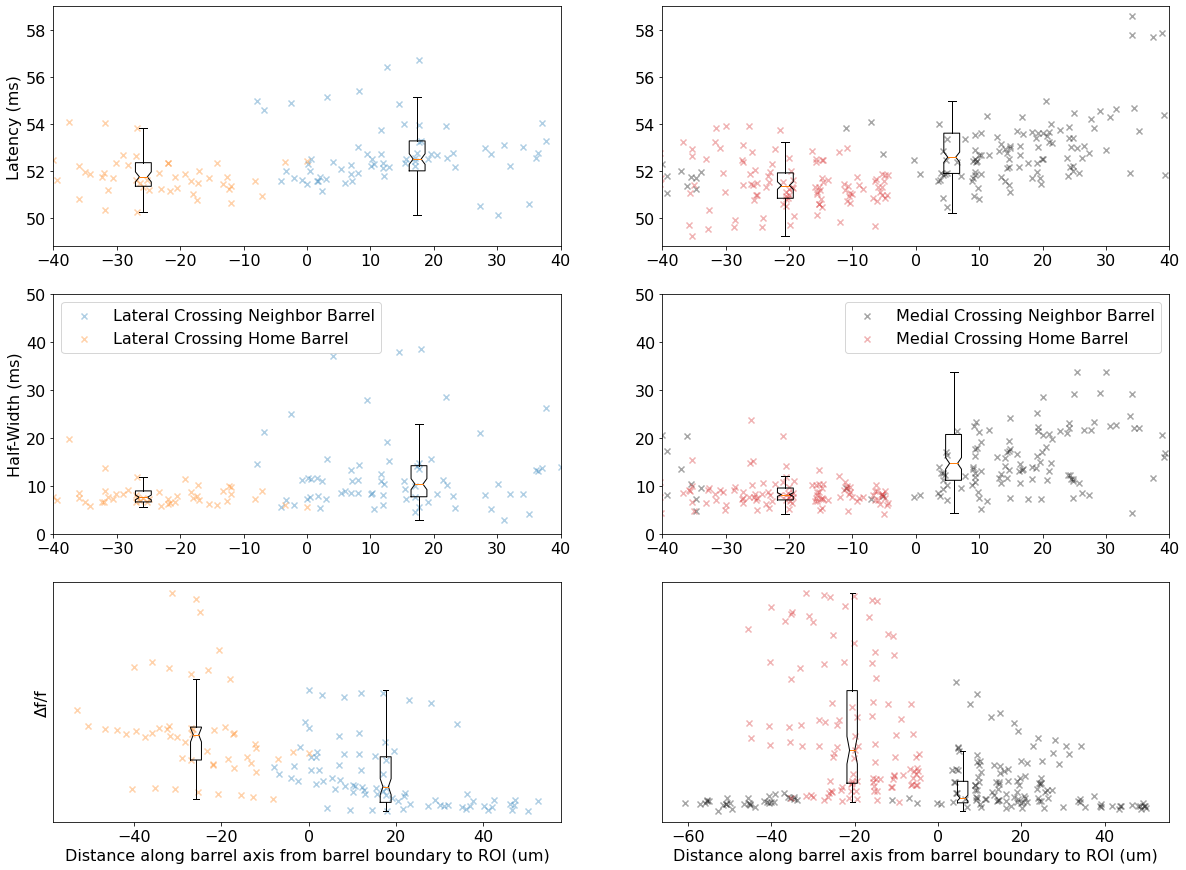

In [260]:
# plot latency vs electrode distance for each crossing direction
# optional amp cutoff
amp_cutoff = None
if amp_cutoff is not None:
    pixel_df = pixel_df[pixel_df['Value'] > amp_cutoff]
plt.rcParams.update({'font.size': 16})
for dist_type in ["Distance", "Distance_Along_Barrel_Axis"]:
    handles = []
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    colors = ['tab:blue', 'black', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    for i, direction in enumerate(crossing_directions):
        df = pixel_df[pixel_df['Crossing_Direction'] == direction]
        
        # split this out by whether Barrel == Home_Barrel or not
        home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
        neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

        lat_home = home_barrel_df[(home_barrel_df['Value_lat'] < 1000) & (home_barrel_df['Value_lat'] > 48.8)]
        hw_home = home_barrel_df[(home_barrel_df['Value_hw'] < 1000) & (home_barrel_df['Value_hw'] > 0)]
        lat_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_lat'] < 1000) & (neighbor_barrel_df['Value_lat'] > 48.8)]
        hw_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_hw'] < 1000) & (neighbor_barrel_df['Value_hw'] > 0)]
        amp_home = home_barrel_df[(home_barrel_df['Value'] < 1000) & (home_barrel_df['Value'] > 0)]
        amp_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value'] < 1000) & (neighbor_barrel_df['Value'] > 0)]

        alph = 0.35
        l1 = ax[0][i].scatter(lat_neighbor[dist_type], lat_neighbor['Value_lat'], 
                            label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[i], marker='x')
        l2 = ax[1][i].scatter(hw_neighbor[dist_type], hw_neighbor['Value_hw'],
                            label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[i], marker='x')
        l5 = ax[2][i].scatter(amp_neighbor[dist_type], amp_neighbor['Value'],
                            label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[i], marker='x')
        l3 = ax[0][i].scatter(lat_home[dist_type], lat_home['Value_lat'], 
                            label=direction + " Crossing Home Barrel", alpha=alph, c=colors[i+2], marker='x')
        l4 = ax[1][i].scatter(hw_home[dist_type], hw_home['Value_hw'],
                            label=direction + " Crossing Home Barrel", alpha=alph, c=colors[i+2], marker='x')
        l6 = ax[2][i].scatter(amp_home[dist_type], amp_home['Value'],
                            label=direction + " Crossing Home Barrel", alpha=alph, c=colors[i+2], marker='x')
        
        # plot box and whisker plots for each group
        ax[0][i].boxplot([lat_neighbor['Value_lat']], positions=[np.mean(lat_neighbor[dist_type])], 
                         manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[1][i].boxplot([hw_neighbor['Value_hw']], positions=[np.mean(hw_neighbor[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[2][i].boxplot([amp_neighbor['Value']], positions=[np.mean(amp_neighbor[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[0][i].boxplot([lat_home['Value_lat']], positions=[np.mean(lat_home[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[1][i].boxplot([hw_home['Value_hw']], positions=[np.mean(hw_home[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[2][i].boxplot([amp_home['Value']], positions=[np.mean(amp_home[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        
        '''def plot_sig_bar(df_home, df_neighbor, dist_type, ax, i, j, height):
            lx = np.mean(df_home[dist_type])
            rx = np.mean(df_neighbor[dist_type])
            barx = [lx, lx, rx, rx]
            bary = [height, height * 1.01, height * 1.01, height]
            ax[j][i].plot(barx, bary, color='black')
            ax[j][i].annotate("p < 0.01", (np.mean([lx, rx])-3, height * 1.04), color='black', fontsize=12)
        # are there any significant differences between the groups
        # Welch's two-sided t-test 
        t_stat, p_val = ttest_ind(lat_home['Value_lat'], lat_neighbor['Value_lat'], alternative='two-sided', equal_var=False)
        if p_val < 0.05:
            plot_sig_bar(lat_home, lat_neighbor, dist_type, ax, i, 0, 55)
            
        print("p_val for latency home vs neighbor:", p_val)
        t_stat, p_val = ttest_ind(hw_neighbor['Value_hw'], hw_home['Value_hw'], alternative='two-sided',
                                    equal_var=False)
        if p_val < 0.05:
            plot_sig_bar(hw_neighbor, hw_home, dist_type, ax, i, 1, 32)

        print("p_val for half-width home vs neighbor:", p_val)
        t_stat, p_val = ttest_ind(amp_neighbor['Value'], amp_home['Value'], alternative='two-sided',
                                    equal_var=False)
        print("p_val for amp home vs neighbor:", p_val)
        if p_val < 0.05:
            plot_sig_bar(amp_neighbor, amp_home, dist_type, ax, i, 2, 0.008)'''

    ax[0][0].set_ylabel("Latency (ms)")
    ax[1][0].set_ylabel("Half-Width (ms)")
    ax[2][0].set_ylabel("Δf/f")
    ax[2][0].set_yticks([])
    ax[2][1].set_yticks([])
    for i in range(2):
        if dist_type == "Distance":
            ax[2][i].set_xlabel("Electrode distance to ROI (um)")
        elif dist_type == "Distance_Along_Barrel_Axis":
            ax[2][i].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")

    for i in range(2):
        ax[0][i].set_ylim(48.8, 59)
        ax[1][i].set_ylim(0, 50)
        for j in range(2):
            if dist_type == "Distance":
                ax[j][i].set_xlim(0, 60)
            elif dist_type == "Distance_Along_Barrel_Axis":
                ax[j][i].set_xlim(-40, 40)
        
    ax[1][0].legend()
    ax[1][1].legend()
    plt.show()

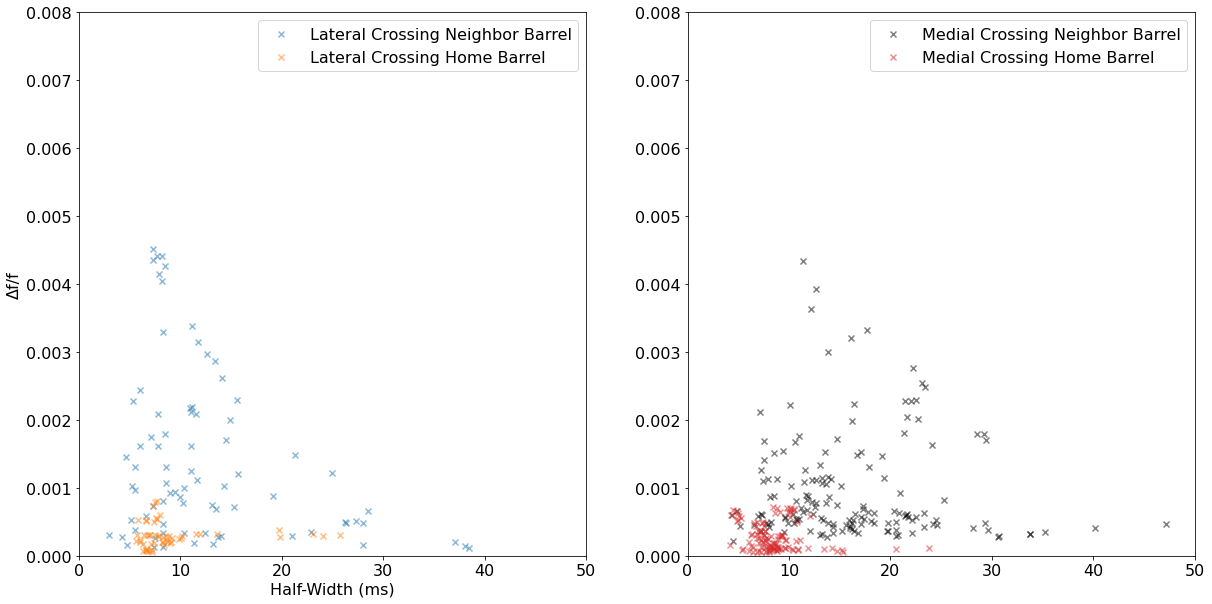

In [261]:
# Is there correlation between amplitude and half-width?
# Make a scatter plot of amplitude vs half-width
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, direction in enumerate(crossing_directions):
    df = pixel_df[pixel_df['Crossing_Direction'] == direction]
    # split this out by whether Barrel == Home_Barrel or not
    home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
    neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

    l1 = ax[i].scatter( neighbor_barrel_df['Value_hw'], neighbor_barrel_df['Value'],
                        label=direction + " Crossing Neighbor Barrel", alpha=0.5, c=colors[i], marker='x')
    l2 = ax[i].scatter(home_barrel_df['Value_hw'], home_barrel_df['Value'] / 10, 
                        label=direction + " Crossing Home Barrel", alpha=0.5, c=colors[i+2], marker='x')
    
    # boxplots
    '''ax[i].boxplot([neighbor_barrel_df['Value']], positions=[np.median(neighbor_barrel_df['Value_hw'])], 
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    ax[i].boxplot([home_barrel_df['Value']], positions=[np.median(home_barrel_df['Value_hw'])],
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    
    # plot horizontal boxplots for halfwidth
    ax[i].boxplot([neighbor_barrel_df['Value_hw']], positions=[np.median(neighbor_barrel_df['Value'])], 
                    manage_ticks=False, notch=False, widths=0.025, showfliers=False, vert=False, showbox=True)
    ax[i].boxplot([home_barrel_df['Value_hw']], positions=[np.median(home_barrel_df['Value'])],
                    manage_ticks=False, notch=False, widths=0.025, showfliers=False, vert=False, showbox=True)'''

# remove these tests in favor of Linear mixed effects model
'''    # are there any significant differences between the groups
    # Welch's two-sided t-test
    t_stat, p_val = ttest_ind(neighbor_barrel_df['Value'], home_barrel_df['Value'], alternative='two-sided', equal_var=False)
    print("p_val for amp home vs neighbor:", p_val)
    if p_val < 0.05:
        lx = np.median(home_barrel_df['Value_hw'])
        rx = np.median(neighbor_barrel_df['Value_hw'])
        barx = [lx, lx, rx, rx]
        bary = [0.1, 0.11, 0.11, 0.1]
        ax[i].plot(barx, bary, color='black')
        ax[i].annotate("p < 0.01", (np.mean([lx, rx])-0.5, 0.012), color='black', fontsize=12)

    # are there significant differences in half-width
    t_stat, p_val = ttest_ind(neighbor_barrel_df['Value_hw'], home_barrel_df['Value_hw'], alternative='two-sided', equal_var=False)
    print("p_val for hw home vs neighbor:", p_val)
    if p_val < 0.05:
        lx = np.median(home_barrel_df['Value'])
        rx = np.median(neighbor_barrel_df['Value'])
        barx = [lx, lx, rx, rx]
        bary = [0.1, 0.11, 0.11, 0.1]
        ax[i].plot(bary, barx, color='black')
        ax[i].annotate("p < 0.01", (0.012, np.mean([lx, rx])-0.5), color='black', fontsize=12)'''
ax[0].set_ylabel("Δf/f")
ax[0].set_xlabel("Half-Width (ms)")
ax[0].legend()
ax[1].legend()
for i in range(2):
    ax[i].set_xlim(0, 50)
    ax[i].set_ylim(0, 0.008)

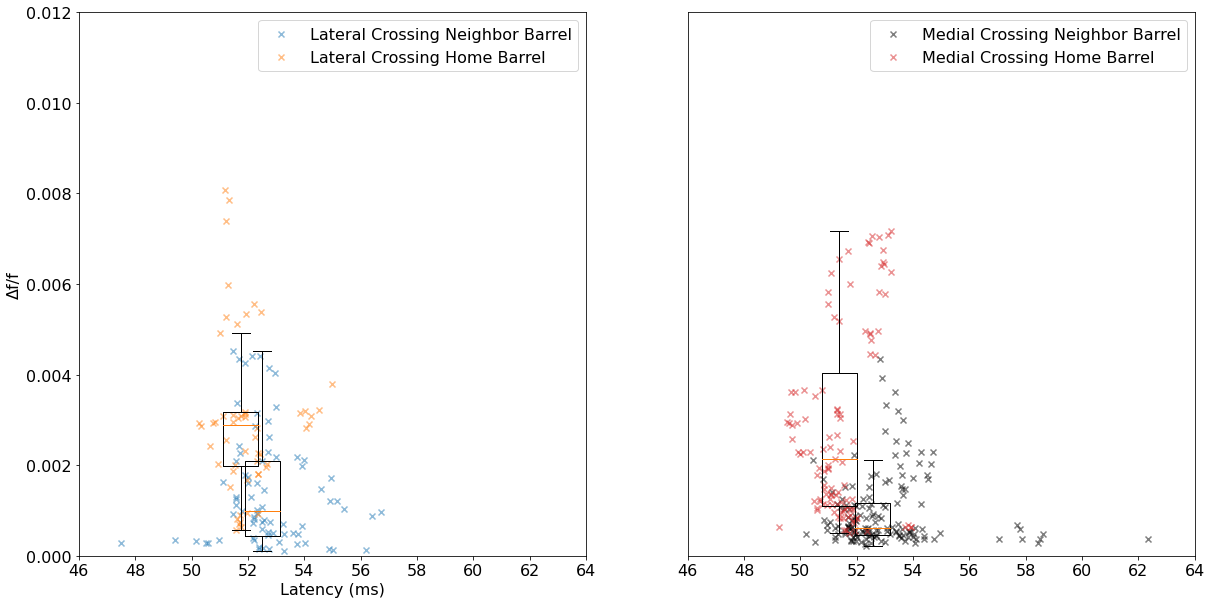

In [262]:
# is there correlation between latency and amplitude?
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, direction in enumerate(crossing_directions):
    df = pixel_df[pixel_df['Crossing_Direction'] == direction]
    # split this out by whether Barrel == Home_Barrel or not
    home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
    neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

    l1 = ax[i].scatter( neighbor_barrel_df['Value_lat'], neighbor_barrel_df['Value'],
                        label=direction + " Crossing Neighbor Barrel", alpha=0.5, c=colors[i], marker='x')
    l2 = ax[i].scatter(home_barrel_df['Value_lat'], home_barrel_df['Value'], 
                        label=direction + " Crossing Home Barrel", alpha=0.5, c=colors[i+2], marker='x')
    
    # boxplots
    ax[i].boxplot([neighbor_barrel_df['Value']], positions=[np.median(neighbor_barrel_df['Value_lat'])], 
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    ax[i].boxplot([home_barrel_df['Value']], positions=[np.median(home_barrel_df['Value_lat'])],
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    
ax[0].set_ylabel("Δf/f")
ax[0].set_xlabel("Latency (ms)")
ax[1].set_yticks([])
ax[0].legend()
ax[1].legend()
for i in range(2):
    ax[i].set_xlim(46, 64)
    ax[i].set_ylim(0, 0.012)
plt.show()

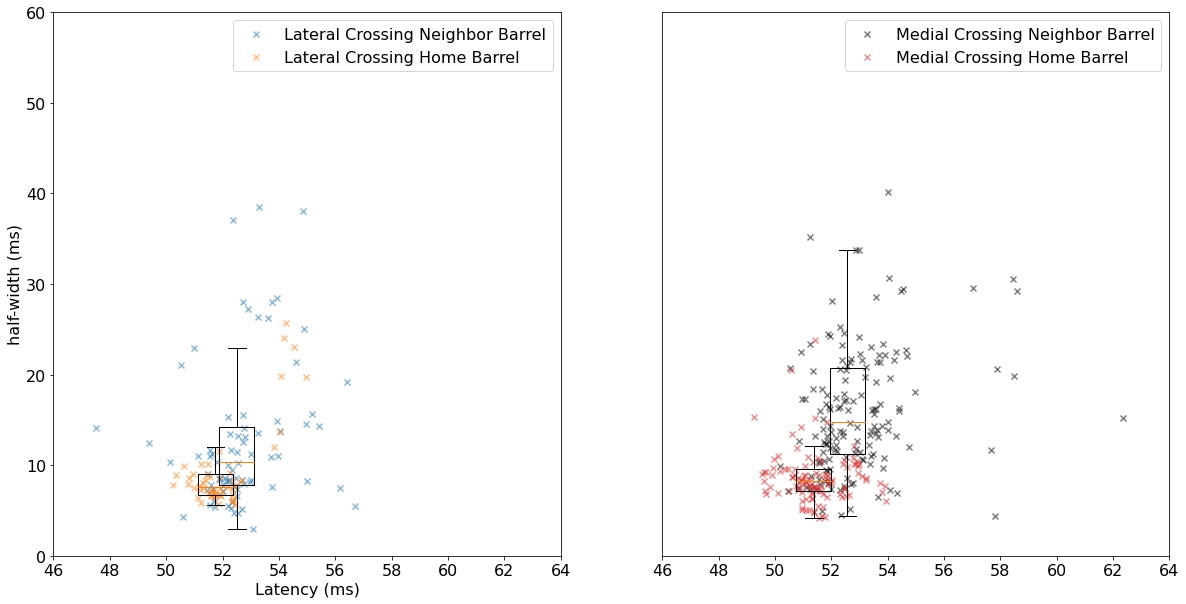

In [263]:
# correlation between half-width and latency?
# is there correlation between latency and amplitude?
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, direction in enumerate(crossing_directions):
    df = pixel_df[pixel_df['Crossing_Direction'] == direction]
    # split this out by whether Barrel == Home_Barrel or not
    home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
    neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

    l1 = ax[i].scatter( neighbor_barrel_df['Value_lat'], neighbor_barrel_df['Value_hw'],
                        label=direction + " Crossing Neighbor Barrel", alpha=0.5, c=colors[i], marker='x')
    l2 = ax[i].scatter(home_barrel_df['Value_lat'], home_barrel_df['Value_hw'], 
                        label=direction + " Crossing Home Barrel", alpha=0.5, c=colors[i+2], marker='x')
    
    # boxplots
    ax[i].boxplot([neighbor_barrel_df['Value_hw']], positions=[np.median(neighbor_barrel_df['Value_lat'])], 
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    ax[i].boxplot([home_barrel_df['Value_hw']], positions=[np.median(home_barrel_df['Value_lat'])],
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    
ax[0].set_ylabel("half-width (ms)")
ax[0].set_xlabel("Latency (ms)")
ax[1].set_yticks([])
ax[0].legend()
ax[1].legend()
for i in range(2):
    ax[i].set_xlim(46, 64)
    ax[i].set_ylim(0, 60)
plt.show()

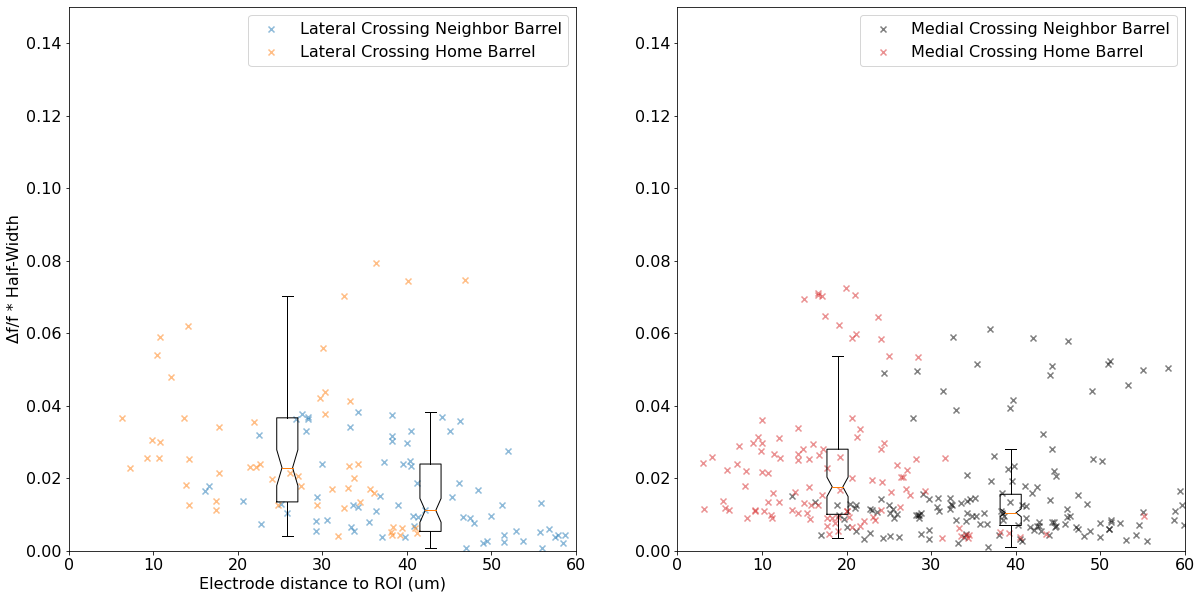

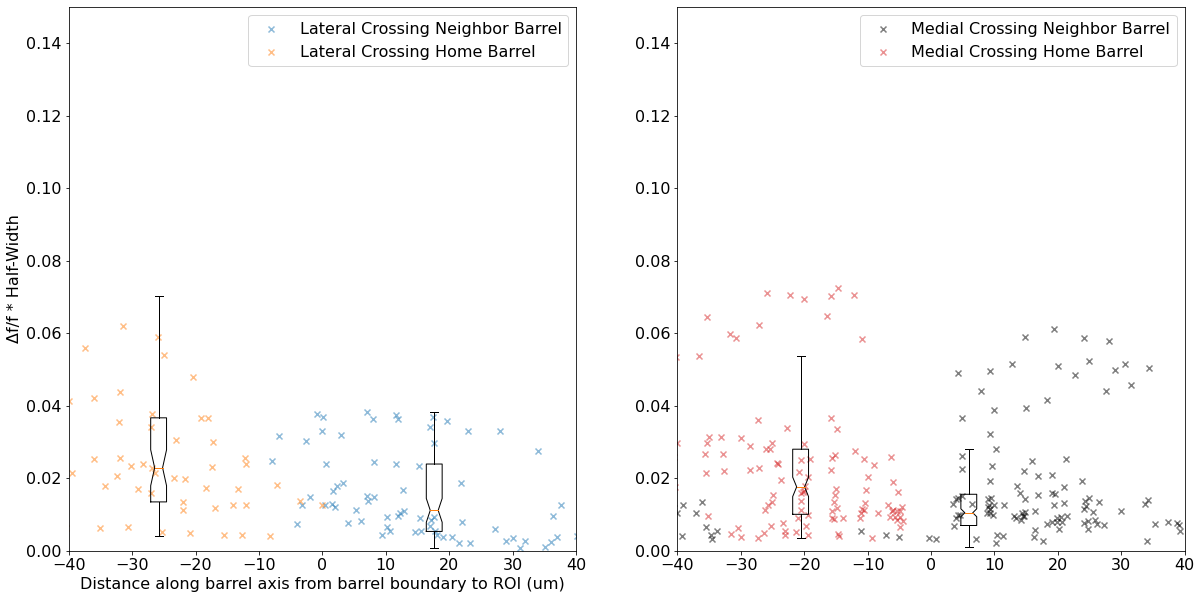

In [264]:
# scatter plot amp * hw versus distance
plt.rcParams.update({'font.size': 16})

for dist_type in ["Distance", "Distance_Along_Barrel_Axis"]:
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for i, direction in enumerate(crossing_directions):
        df = pixel_df[pixel_df['Crossing_Direction'] == direction]
        # split this out by whether Barrel == Home_Barrel or not
        home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
        neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

        l1 = ax[i].scatter( neighbor_barrel_df[dist_type], neighbor_barrel_df['Value'] * neighbor_barrel_df['Value_hw'],
                            label=direction + " Crossing Neighbor Barrel", alpha=0.5, c=colors[i], marker='x')
        l2 = ax[i].scatter(home_barrel_df[dist_type], home_barrel_df['Value'] * home_barrel_df['Value_hw'], 
                            label=direction + " Crossing Home Barrel", alpha=0.5, c=colors[i+2], marker='x')
        
        # boxplots 
        ax[i].boxplot([neighbor_barrel_df['Value'] * neighbor_barrel_df['Value_hw']], positions=[np.mean(neighbor_barrel_df[dist_type])], 
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[i].boxplot([home_barrel_df['Value'] * home_barrel_df['Value_hw']], positions=[np.mean(home_barrel_df[dist_type])],
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    ax[0].set_ylabel("Δf/f * Half-Width")
    if dist_type == "Distance":
        ax[0].set_xlabel("Electrode distance to ROI (um)")
    elif dist_type == "Distance_Along_Barrel_Axis":
        ax[0].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")        
    ax[0].legend()
    ax[1].legend()
    for i in range(2):
        if dist_type == "Distance":
            ax[i].set_xlim(0, 60)
        elif dist_type == "Distance_Along_Barrel_Axis":
            ax[i].set_xlim(-40, 40)
        ax[i].set_ylim(0, 0.15)
    plt.show()

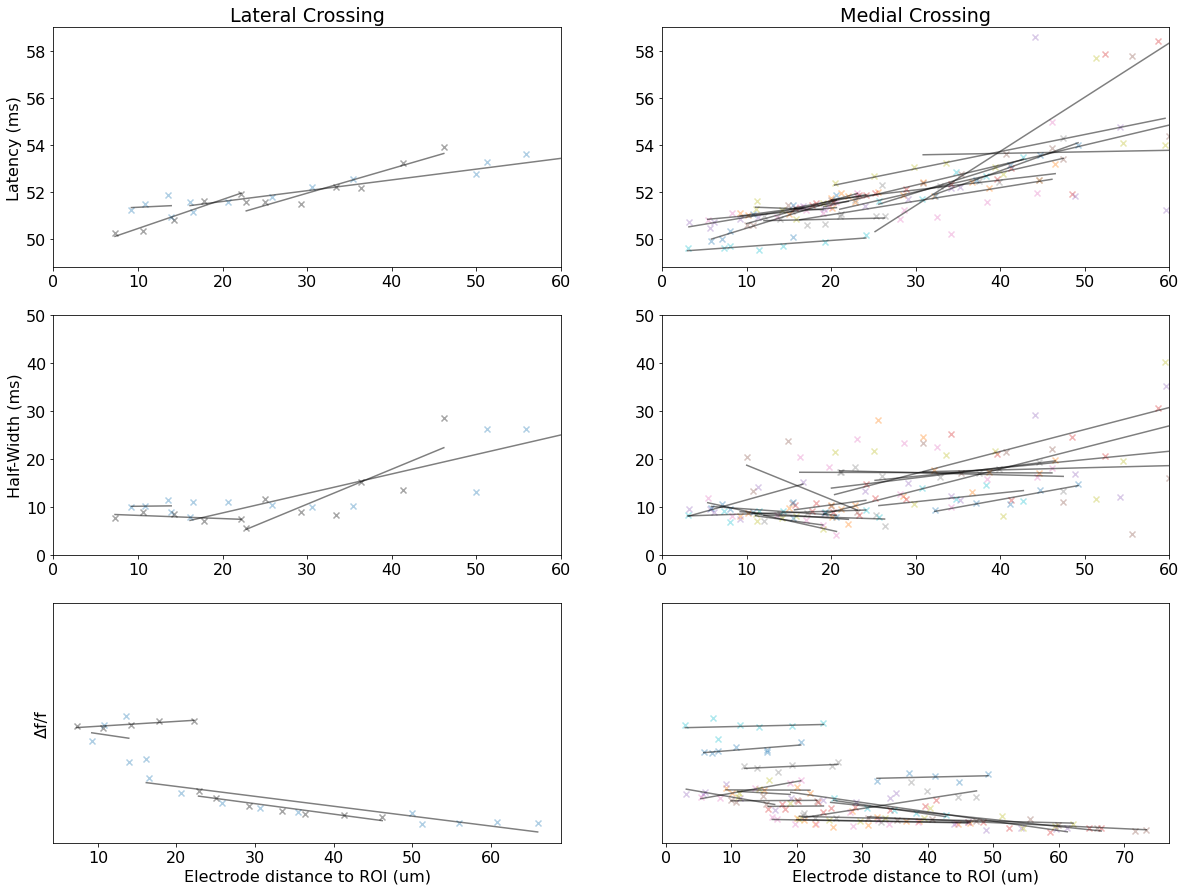

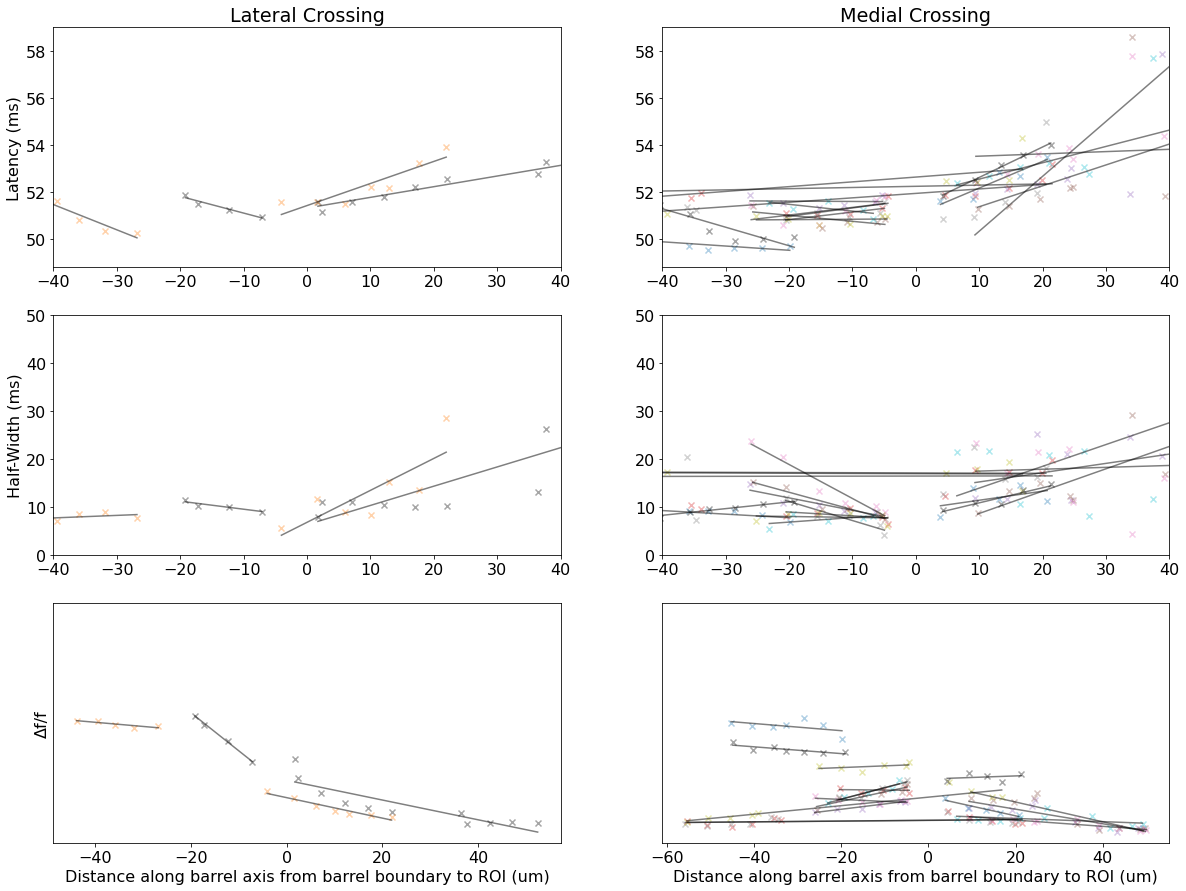

In [265]:
# plot latency vs electrode distance for each crossing direction
# optional amp cutoff
amp_cutoff = None
if amp_cutoff is not None:
    pixel_df = pixel_df[pixel_df['Value'] > amp_cutoff]
plt.rcParams.update({'font.size': 16})
linear_regressions = {}
k = -1
for dist_type in ["Distance", "Distance_Along_Barrel_Axis"]:
    handles = []
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    colors = ['tab:blue', 'black', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',]
    for i, direction in enumerate(crossing_directions):
        df = pixel_df[pixel_df['Crossing_Direction'] == direction]

        # use a different color for each slice/loc
        for jx, date in enumerate(df['Date'].unique()):
            df_date = df[df['Date'] == date]
            for jxx, slic_loc_id in enumerate(df_date['Slice_Loc'].unique()):
                j = jx + jxx
                df_slic_loc = df_date[(df_date['Slice_Loc'] == slic_loc_id)]

                # split this out by whether Barrel == Home_Barrel or not
                home_barrel_df = df_slic_loc[df_slic_loc['Barrel'] == df_slic_loc['Home_Barrel']]
                neighbor_barrel_df = df_slic_loc[df_slic_loc['Barrel'] != df_slic_loc['Home_Barrel']]

                lat_home = home_barrel_df[(home_barrel_df['Value_lat'] < 1000) & (home_barrel_df['Value_lat'] > 48.8)]
                hw_home = home_barrel_df[(home_barrel_df['Value_hw'] < 1000) & (home_barrel_df['Value_hw'] > 0)]
                lat_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_lat'] < 1000) & (neighbor_barrel_df['Value_lat'] > 48.8)]
                hw_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_hw'] < 1000) & (neighbor_barrel_df['Value_hw'] > 0)]
                amp_home = home_barrel_df[(home_barrel_df['Value'] < 1000) & (home_barrel_df['Value'] > 0)]
                amp_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value'] < 1000) & (neighbor_barrel_df['Value'] > 0)]
                k = (k+1) % len(colors)

                alph = 0.35
                l1 = ax[0][i].scatter(lat_neighbor[dist_type], lat_neighbor['Value_lat'], 
                                    label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[k], marker='x')
                l2 = ax[1][i].scatter(hw_neighbor[dist_type], hw_neighbor['Value_hw'],
                                    label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[k], marker='x')
                l5 = ax[2][i].scatter(amp_neighbor[dist_type], amp_neighbor['Value'],
                                    label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[k], marker='x')
                l3 = ax[0][i].scatter(lat_home[dist_type], lat_home['Value_lat'], 
                                    label=direction + " Crossing Home Barrel", alpha=alph, c=colors[k], marker='x')
                l4 = ax[1][i].scatter(hw_home[dist_type], hw_home['Value_hw'],
                                    label=direction + " Crossing Home Barrel", alpha=alph, c=colors[k], marker='x')
                l6 = ax[2][i].scatter(amp_home[dist_type], amp_home['Value'],
                                    label=direction + " Crossing Home Barrel", alpha=alph, c=colors[k], marker='x')
                
                # fit a linear regression and plot a line for each slice/loc
                for ix, (home, neighbor, value_type) in enumerate([(lat_home, lat_neighbor, 'Value_lat'), 
                                                                   (hw_home, hw_neighbor, 'Value_hw'), 
                                                                   (amp_home, amp_neighbor, 'Value')]):
                    for ixx, df in enumerate([home, neighbor]):
                        if len(df) < 2:
                            continue
                        slope, intercept, r_value, p_value, std_err = linregress(df[dist_type], df[value_type])
                        x = np.linspace(min(df[dist_type]), max(df[dist_type]), 100)
                        y = slope * x + intercept
                        ax[ix][i].plot(x, y, color='black', alpha=0.5)

                # repeat the linear regression fits but with each set centered on its mean
                for ix, (home, neighbor, value_type) in enumerate([(lat_home, lat_neighbor, 'Value_lat'), 
                                                                   (hw_home, hw_neighbor, 'Value_hw'), 
                                                                   (amp_home, amp_neighbor, 'Value')]):
                    for ixx, df in enumerate([home, neighbor]):
                        if len(df) < 2:
                            continue
                        slope, intercept, r_value, p_value, std_err = linregress(df[dist_type] - np.mean(df[dist_type]), df[value_type])
                        x = np.linspace(min(df[dist_type]), max(df[dist_type]), 100)
                        y = slope * (x - np.mean(df[dist_type])) + intercept

                        if dist_type not in linear_regressions:
                            linear_regressions[dist_type] = {}
                        if direction not in linear_regressions[dist_type]:
                            linear_regressions[dist_type][direction] = {}
                        if value_type not in linear_regressions[dist_type][direction]:
                            linear_regressions[dist_type][direction][value_type] = {}
                        if ixx not in linear_regressions[dist_type][direction][value_type]:
                            linear_regressions[dist_type][direction][value_type][ixx] = {}
                        linear_regressions[dist_type][direction][value_type][ixx][slic_loc_id] = [slope, intercept, r_value, p_value, std_err]

    ax[0][0].set_ylabel("Latency (ms)")
    ax[1][0].set_ylabel("Half-Width (ms)")
    ax[2][0].set_ylabel("Δf/f")
    ax[2][0].set_yticks([])
    ax[2][1].set_yticks([])
    for i in range(2):
        if dist_type == "Distance":
            ax[2][i].set_xlabel("Electrode distance to ROI (um)")
        elif dist_type == "Distance_Along_Barrel_Axis":
            ax[2][i].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")

    for i in range(2):
        ax[0][i].set_ylim(48.8, 59)
        ax[1][i].set_ylim(0, 50)
        ax[2][i].set_ylim(0, 0.006)
        for j in range(2):
            if dist_type == "Distance":
                ax[j][i].set_xlim(0, 60)
            elif dist_type == "Distance_Along_Barrel_Axis":
                ax[j][i].set_xlim(-40, 40)
        ax[0][i].set_title(crossing_directions[i] + " Crossing")
        
    #ax[1][0].legend()
    #ax[1][1].legend()
    plt.show()

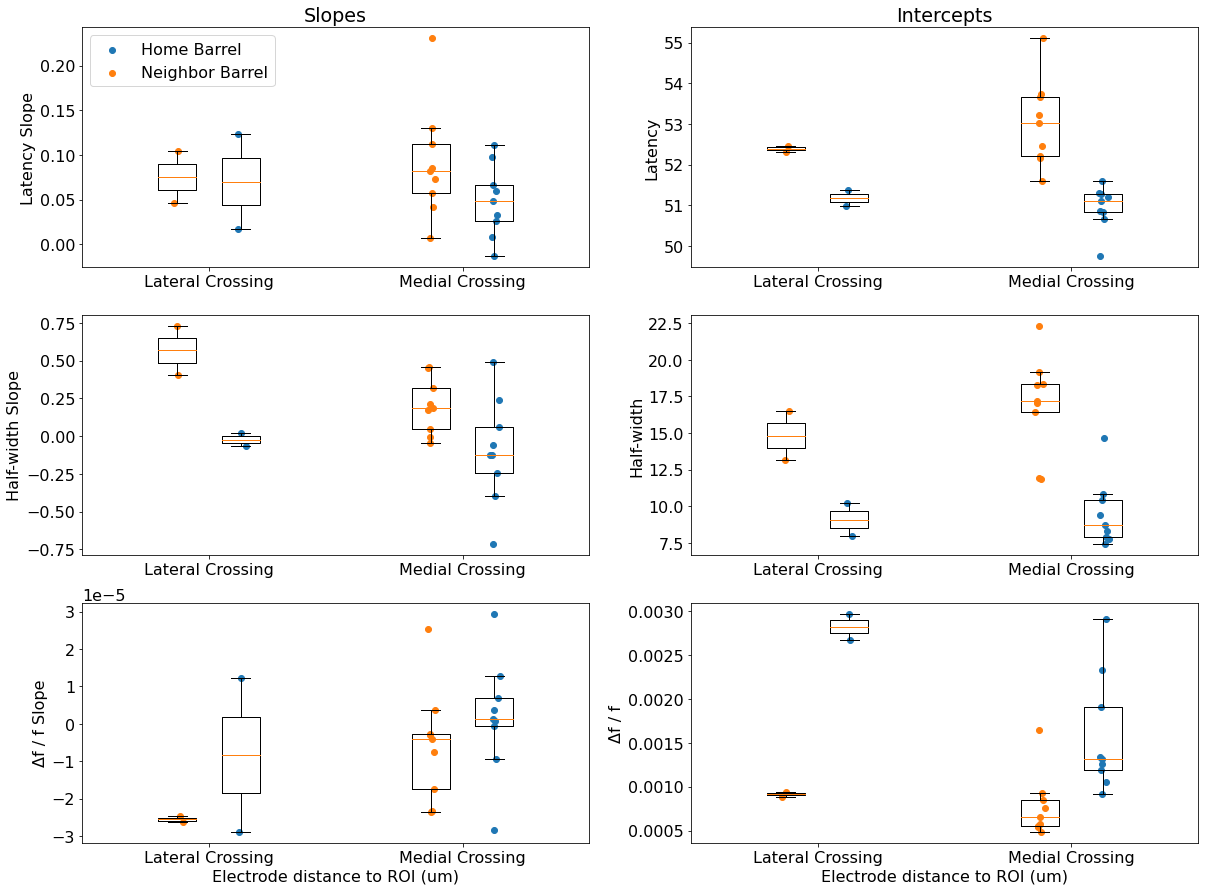

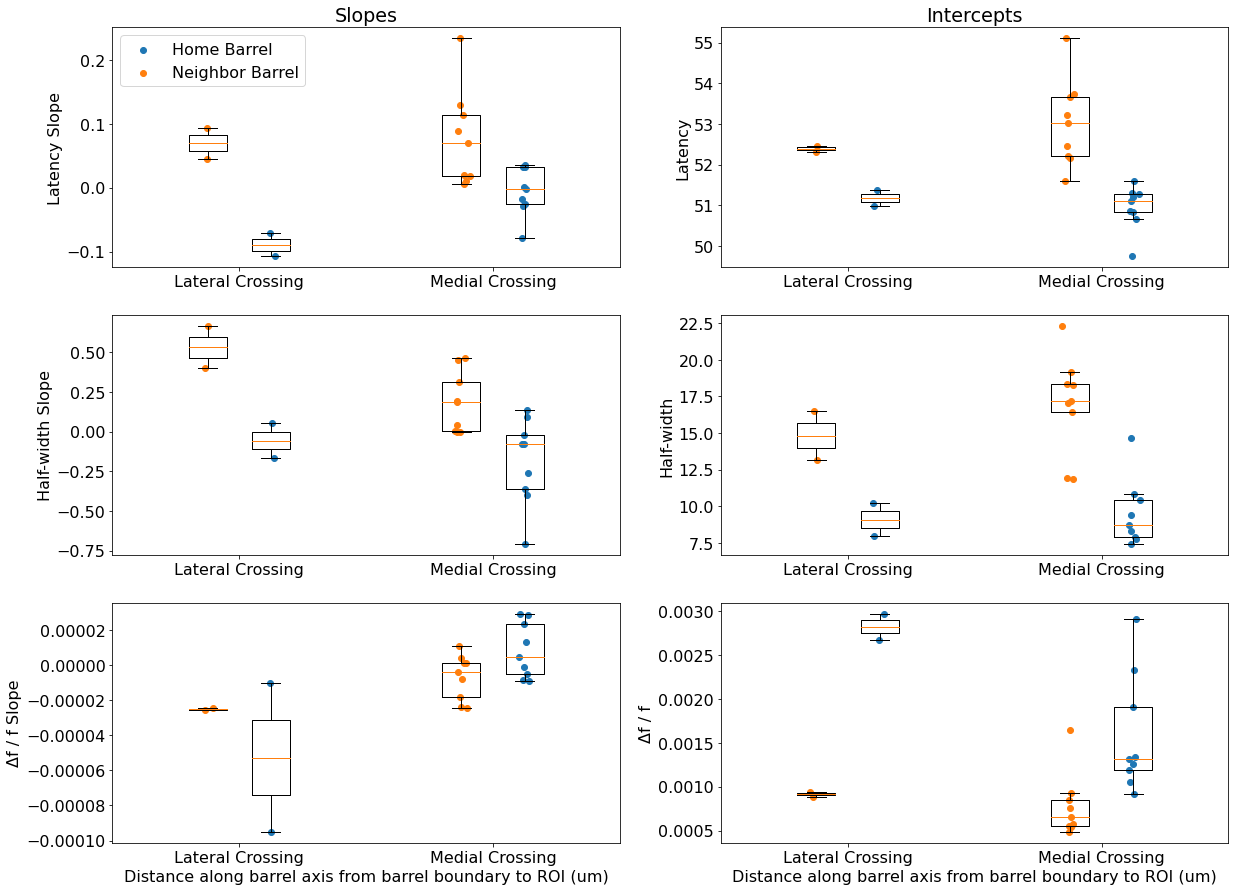

In [266]:
# plot distribution of each slope and intercept for each value type, direction, and distance type
colors = ['tab:blue','tab:orange', 'black', 'tab:green']
handles = []
for dist_type in linear_regressions:
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    for i, direction in enumerate(crossing_directions):
        for j, (value_type, value_name) in enumerate([['Value_lat', "Latency"], ['Value_hw', 'Half-width'], ['Value', 'Δf / f']]):
            for ixx, home_barrel in enumerate(["Home", "Neighbor"]):

                slopes = []
                intercepts = []
                for slic_loc_id in linear_regressions[dist_type][direction][value_type][ixx]:
                    slopes.append(linear_regressions[dist_type][direction][value_type][ixx][slic_loc_id][0])
                    intercepts.append(linear_regressions[dist_type][direction][value_type][ixx][slic_loc_id][1])
                x_jitter = np.random.normal(0, 0.01, len(slopes)) + i - (ixx * 0.25) + 0.125
                l = ax[j][0].scatter(x_jitter, slopes, label=home_barrel + " Barrel", c=colors[ixx])
                handles.append(l)
                x_jitter = np.random.normal(0, 0.01, len(intercepts)) + i - (ixx * 0.25) + 0.125
                ax[j][1].scatter(x_jitter, intercepts, label=direction, c=colors[ixx])

                # add boxplots
                ax[j][0].boxplot([slopes], positions=[i - (ixx * 0.25) + 0.125], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
                ax[j][1].boxplot([intercepts], positions=[i - (ixx * 0.25) + 0.125], manage_ticks=False, notch=False, widths=0.15, showfliers=False)


                ax[0][0].set_title("Slopes")
                ax[0][1].set_title("Intercepts")
                ax[j][i].set_xlim(-0.5, 1.5)
                ax[j][i].set_xticks([])
                ax[j][i].set_xticks([0, 1])
                ax[j][i].set_xticklabels([cd + " Crossing" for cd in crossing_directions])
                ax[j][0].set_ylabel(value_name + " Slope")
                ax[j][1].set_ylabel(value_name)
                if dist_type == "Distance":
                    ax[2][i].set_xlabel("Electrode distance to ROI (um)")
                elif dist_type == "Distance_Along_Barrel_Axis":
                    ax[2][i].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")


    ax[0][0].legend(handles=[handles[0], handles[-1]], labels=["Home Barrel", "Neighbor Barrel"])
    plt.show()

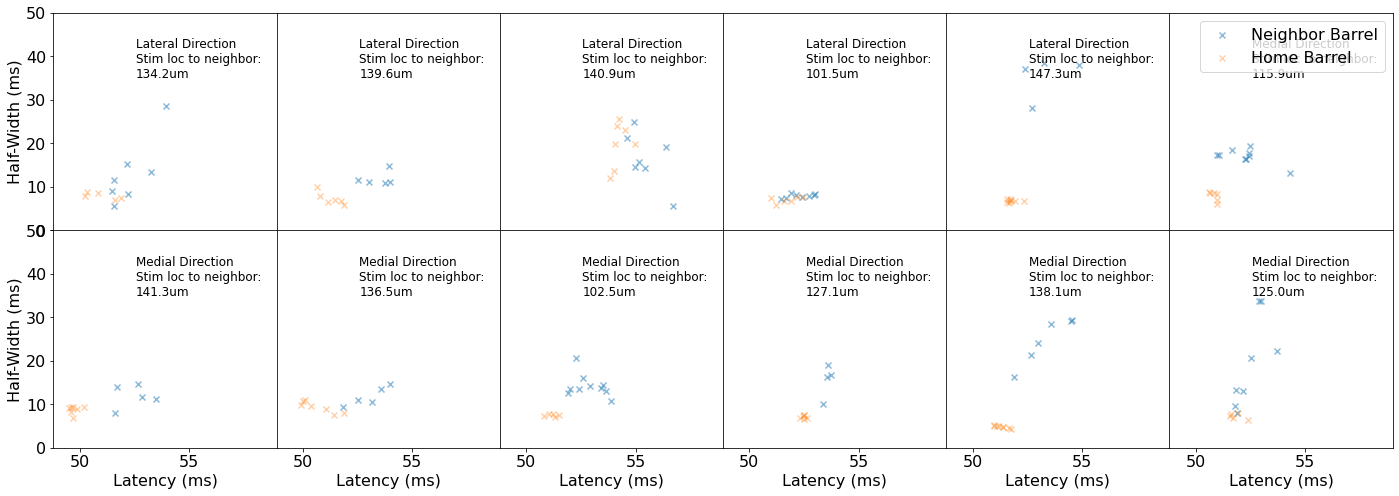

Total plots: 12


In [267]:
# create visualization of half-width versus latency with a different color for each slice/loc
plt.rcParams.update({'font.size': 16})
n_rows = 2
fig, ax = plt.subplots(2, 6, figsize=(24, n_rows * 4))
plt.subplots_adjust(wspace=0, hspace=0)

k_plot = 0
for i, direction in enumerate(crossing_directions):
    df = pixel_df[pixel_df['Crossing_Direction'] == direction]
    

    for jx, date in enumerate(df['Date'].unique()):
        df_date = df[df['Date'] == date]
        for jxx, slic_loc_id in enumerate(df_date['Slice_Loc'].unique()):
            j = jx + jxx
            df_slic_loc = df_date[(df_date['Slice_Loc'] == slic_loc_id)]

            # do not plot if stim_distance2 not centered, esp. stim is too close to the barrel boundary
            stim_dist2 = df_slic_loc['Stim_Distance2'].values[0]
            if not (100 < stim_dist2 < 150):
                continue

            # split this out by whether Barrel == Home_Barrel or not
            home_barrel_df = df_slic_loc[df_slic_loc['Barrel'] == df_slic_loc['Home_Barrel']]
            neighbor_barrel_df = df_slic_loc[df_slic_loc['Barrel'] != df_slic_loc['Home_Barrel']]

            i_plot = k_plot % 6
            j_plot = k_plot // 6

            l1 = ax[j_plot][i_plot].scatter( neighbor_barrel_df['Value_lat'], neighbor_barrel_df['Value_hw'],
                                label=direction + " Crossing Neighbor Barrel", alpha=0.5, marker='x')

            l2 = ax[j_plot][i_plot].scatter(home_barrel_df['Value_lat'], home_barrel_df['Value_hw'], 
                                label=direction + " Crossing Home Barrel", alpha=0.35, c='tab:orange', marker='x')
            
            ax[j_plot][i_plot].annotate(direction + " Direction\nStim loc to neighbor:\n" + str(stim_dist2)[:5] + "um", 
                                        (0.37, 0.7), xycoords='axes fraction', fontsize=12)
            
            k_plot += 1

for i in range(6):
    for j in range(n_rows):
        ax[j][i].set_xlim(48.8, 59)
        ax[j][i].set_ylim(0, 50)

        if j == n_rows - 1:
            ax[j][i].set_xlabel("Latency (ms)")
        else:
            ax[j][i].set_xticks([])
        if i == 0:
            ax[j][i].set_ylabel("Half-Width (ms)")
        else:
            ax[j][i].set_yticks([])
ax[0][5].legend(handles=[l1, l2], labels=["Neighbor Barrel", "Home Barrel"])
plt.show()
print("Total plots:", k_plot)


In [268]:
# merge coronal and sagittal data
merge_data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
coronal_df = pd.read_csv(merge_data_dir + "coronal-crossing/coronal_crossing_final_by_" + roi_type + ".csv")
sagittal_df = pd.read_csv(merge_data_dir + "sagittal/sagittal_crossing_final_by_" + roi_type + ".csv")

# mark the slice/loc as coronal or sagittal
coronal_df['Is_Sagittal'] = 0
sagittal_df['Is_Sagittal'] = 1

# merge the two dataframes
merged_df = pd.concat([coronal_df, sagittal_df])
merged_df.to_csv(merge_data_dir + "merged_crossing_final_by_" + roi_type + ".csv", index=False)

p_val for mean latency coronal vs sagittal: 0.06323857919979416
p_val for std Value_lat coronal vs sagittal: 0.3186821730094989
p_val for mean latency coronal vs sagittal: 0.5891927608948605
p_val for std Value_hw coronal vs sagittal: 0.3908115791505792


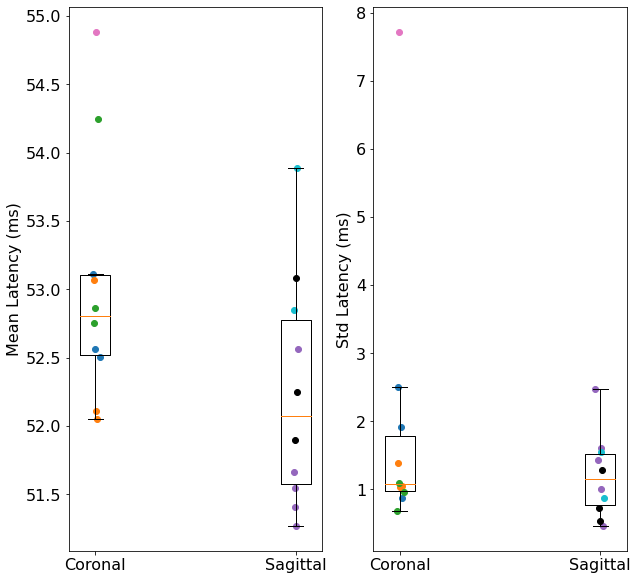

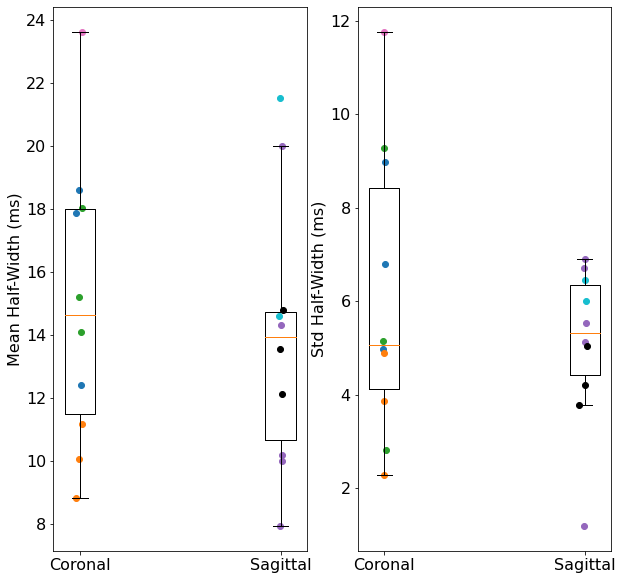

In [269]:
# visualize coronal verus sagittal data by plotting distributions of latency and half-width for neighbor barrels
plt.rcParams.update({'font.size': 16})
df = merged_df[(merged_df['Barrel'] != merged_df['Home_Barrel'])]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:purple', 'black',  'tab:cyan', 'tab:gray', 'tab:olive']
color_by_date = {date: colors[i] for i, date in enumerate(df['Date'].unique())}
# split slic/loc column into slice and loc columns
df = df[df['Value_hw'] > 0]
df['Slice'] = df['Slice_Loc'].apply(lambda x: int(x.split("_")[0]))
df['Loc'] = df['Slice_Loc'].apply(lambda x: int(x.split("_")[1]))

# group by date and slice/loc and get mean and std of latency
grouped = df.groupby(['Date', 'Slice', 'Is_Sagittal'])
for response_type in ['Value_lat', 'Value_hw']:
    means = grouped[response_type].mean().reset_index()
    stds = grouped[response_type].std().reset_index()

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:purple', 'black',  'tab:cyan', 'tab:gray', 'tab:olive']
    color_by_date = {date: colors[i] for i, date in enumerate(df['Date'].unique())}

    means_ = {"Coronal": [],
            "Sagittal": []}
    stds_ = {"Coronal": [],
                "Sagittal": []}
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    for i, is_sagittal in enumerate([0, 1]):
        df_is_sagittal = df[df['Is_Sagittal'] == is_sagittal]
        for j, date in enumerate(df_is_sagittal['Date'].unique()):
            df_date = df_is_sagittal[df_is_sagittal['Date'] == date]
            for jx, slic_id in enumerate(df_date['Slice'].unique()):
                df_slic = df_date[(df_date['Slice'] == slic_id)]

                x_jitter = (np.random.normal(0, 0.01, len(df_slic)) + i)
                

                # plot the mean and std, average over all locations in the slice
                mean = means[(means['Date'] == date) & (means['Slice'] == slic_id) & (means['Is_Sagittal'] == is_sagittal)][response_type].values[0]
                std = stds[(stds['Date'] == date) & (stds['Slice'] == slic_id) & (stds['Is_Sagittal'] == is_sagittal)][response_type].values[0]
                
                if is_sagittal:
                    l2 = ax[0].scatter(x_jitter[0], mean, label="Sagittal", c=color_by_date[date])
                    ax[1].scatter(x_jitter[1], std, label="Sagittal",  c=color_by_date[date])
                    stds_["Sagittal"].append(std)
                    means_["Sagittal"].append(mean)
                else:
                    l1 = ax[0].scatter(x_jitter[0], mean, label="Coronal", c=color_by_date[date])
                    ax[1].scatter(x_jitter[1], std, label="Coronal",  c=color_by_date[date])
                    stds_["Coronal"].append(std)
                    means_["Coronal"].append(mean)

    if response_type == 'Value_lat':
        ax[0].set_ylabel("Mean Latency (ms)")
        ax[1].set_ylabel("Std Latency (ms)")
    elif response_type == 'Value_hw':
        ax[0].set_ylabel("Mean Half-Width (ms)")
        ax[1].set_ylabel("Std Half-Width (ms)")

    # boxplots
    ax[0].boxplot([means_["Coronal"], means_["Sagittal"]], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
    ax[1].boxplot([stds_["Coronal"], stds_["Sagittal"]], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)

    # significance tests between coronal and sagittal (Welch's t-test)
    t_stat, p_val = ttest_ind(means_["Coronal"], means_["Sagittal"], alternative='two-sided', equal_var=False)
    print("p_val for mean latency coronal vs sagittal:", p_val)
    if p_val < 0.05:
        ax[0].plot([0, 1], [58, 58], color='black')
        ax[0].annotate("p = " + str(p_val)[:5], (0.4, 58.3), color='black', fontsize=12)

    t_stat, p_val = ttest_ind(stds_["Coronal"], stds_["Sagittal"], alternative='two-sided', equal_var=False)
    print("p_val for std "+ response_type +" coronal vs sagittal:", p_val)
    if p_val < 0.05:
        ax[1].plot([0, 1], [8.5, 8.5], color='black')
        ax[1].annotate("p = " + str(p_val)[:5], (0.4, 8.85), color='black', fontsize=12)
                    

    for i in range(2):
        ax[i].set_xticks([0, 1])
        ax[i].set_xticklabels(["Coronal", "Sagittal"])

Value_lat Mean slope coronal: 0.08557583622953227 std: 0.018532085457036114
Value_lat Mean slope sagittal: 0.10550041213534628 std: 0.02168470736576735
Value_lat Mean intercept coronal: 51.30859328445293 std: 0.4290765907622089
Value_lat Mean intercept sagittal: 50.43625857669774 std: 0.3524206817707094
p_val for slope coronal vs sagittal: 0.4956851783072025
p_val for intercept coronal vs sagittal: 0.13582753594209007
Max_Amp_Time Mean slope coronal: 0.17413915630874974 std: 0.03326932088038068
Max_Amp_Time Mean slope sagittal: 0.16036641506009966 std: 0.030426162801134398
Max_Amp_Time Mean intercept coronal: 52.792899088686084 std: 0.4265896455085885
Max_Amp_Time Mean intercept sagittal: 53.75932733426678 std: 0.7125069527748398
p_val for slope coronal vs sagittal: 0.7637839280400476
p_val for intercept coronal vs sagittal: 0.26330691880369594
Value_hw Mean slope coronal: 0.481279761183878 std: 0.0549753787107863
Value_hw Mean slope sagittal: 0.37622340295400725 std: 0.082394557958468

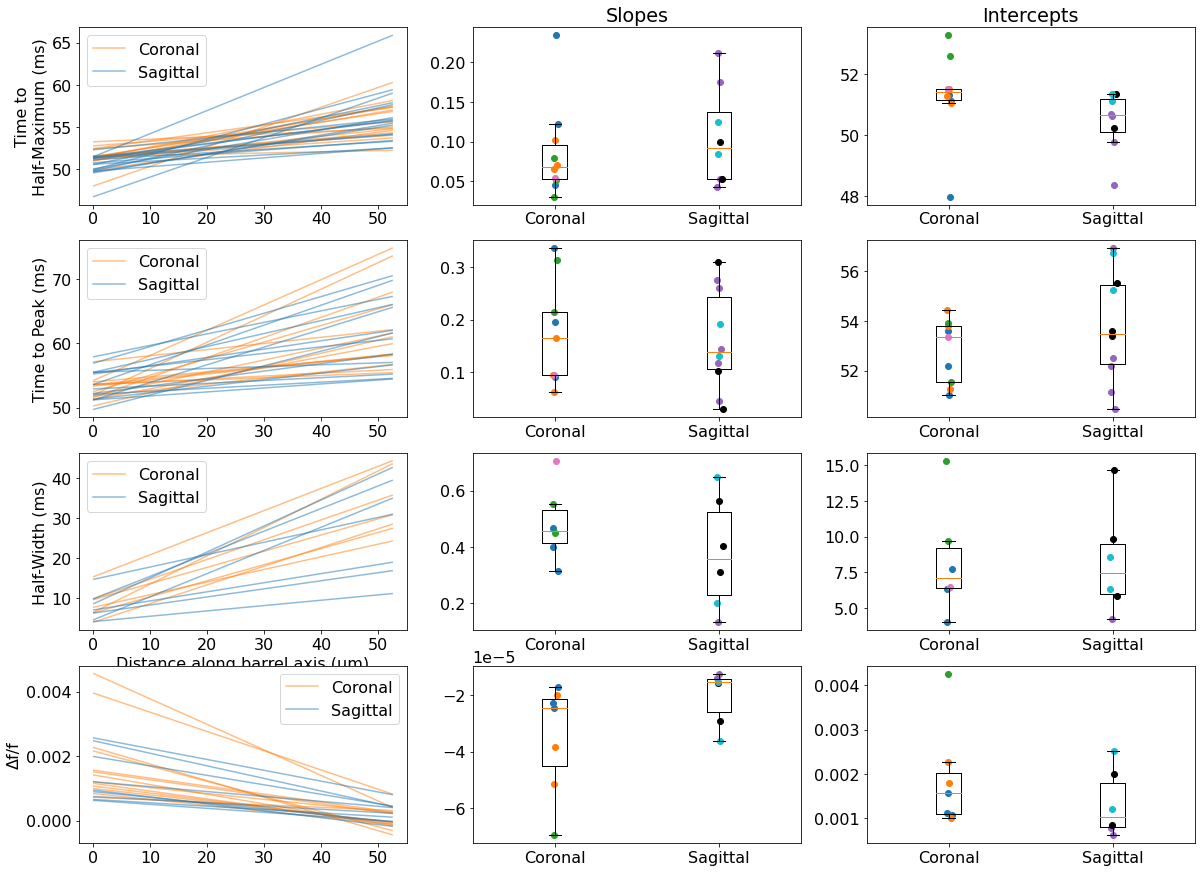

FDR-corrected p-values for slope and intercept of coronal vs sagittal linear regressions: [0.66091357 0.54072399 0.87289592 0.54072399 0.54072399 0.99158829
 0.54072399 0.54072399]


In [282]:
# plot linear regressions for neighbor barrel, coronal versus sagittal
plt.rcParams.update({'font.size': 16})

predictor = 'Distance_Along_Barrel_Axis'
barrel = 'neighbor'
p_vals = []
fig, ax = plt.subplots(4, 3, figsize=(20, 15))
for i_plotrow, response_type in enumerate(['Value_lat', 'Max_Amp_Time', 'Value_hw', 'Value']):
    
    df = merged_df[(merged_df['Value_hw'] > 0) & 
                   (merged_df['Value'] > 0.0001) & (merged_df[predictor] > 0)]
    
    if barrel == 'neighbor':
        df = df[(df['Barrel'] != df['Home_Barrel'])]  # restrict to neighbor barrels
    elif barrel == 'home':
        df = df[(df['Barrel'] == df['Home_Barrel'])]

    df = df[df[response_type] > 0]  # remove any negative values
    linear_regressions = {'coronal': [], 'sagittal': []}
    lin_intercepts = {'coronal': [], 'sagittal': []}
    x_jitter_1 = np.random.normal(0, 0.01, 400)
    x_jitter_2 = np.random.normal(0, 0.01, 400) + 1
    handles = []
    i_jit = 0
    for i, is_sagittal in enumerate([0, 1]):
        df_is_sagittal = df[df['Is_Sagittal'] == is_sagittal]

        # for each date
        for j, date in enumerate(df_is_sagittal['Date'].unique()):
            df_date = df_is_sagittal[df_is_sagittal['Date'] == date]

            
            for jx, slic_id in enumerate(df_date['Slice'].unique()):
                df_slic = df_date[(df_date['Slice'] == slic_id)]

                # for each location, fit a linear regression
                slice_slopes = []
                slice_intercepts = []
                for jxx, loc_id in enumerate(df_slic['Loc'].unique()):
                    df_loc = df_slic[df_slic['Loc'] == loc_id]
                    if len(df_loc) < 3:
                        continue

                    # fit linear regression for latency and distance along barrel axis
                    slope, intercept, r_value, p_value, std_err = linregress(df_loc[predictor], df_loc[response_type])
                    if p_value < 0.025:  # lower p-value threshold to account for FDR
                        if slope < 0 and response_type == 'Value_hw':
                            print(df_loc[predictor], df_loc[response_type])
                        slice_slopes.append(slope)
                        slice_intercepts.append(intercept)
                        
                        x = np.linspace(min(df[predictor]), max(df[predictor]), 100)
                        y = slope * x + intercept
                        l1 = ax[i_plotrow][0].plot(x, y, alpha=0.5, c=("tab:blue" if is_sagittal else "tab:orange"), label=("Sagittal" if is_sagittal else "Coronal"))
                        handles.append(l1[0])

                # plot the mean of the slopes and intercepts for each slice
                if len(slice_slopes) > 0:
                    if is_sagittal:
                        linear_regressions['sagittal'].append(np.mean(slice_slopes))
                        lin_intercepts['sagittal'].append(np.mean(slice_intercepts))
                        ax[i_plotrow][1].scatter(x_jitter_2[i_jit], np.mean(slice_slopes), c=color_by_date[date])
                        ax[i_plotrow][2].scatter(x_jitter_2[i_jit], np.mean(slice_intercepts), c=color_by_date[date])
                    else:
                        linear_regressions['coronal'].append(np.mean(slice_slopes))
                        lin_intercepts['coronal'].append(np.mean(slice_intercepts))
                        ax[i_plotrow][1].scatter(x_jitter_1[i_jit], np.mean(slice_slopes), c=color_by_date[date])
                        ax[i_plotrow][2].scatter(x_jitter_1[i_jit], np.mean(slice_intercepts), c=color_by_date[date])
                    i_jit += 1

    # add boxplots
    ax[i_plotrow][1].boxplot([linear_regressions['coronal'], linear_regressions['sagittal']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
    ax[i_plotrow][2].boxplot([lin_intercepts['coronal'], lin_intercepts['sagittal']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)

    # print the mean and std of the slopes and intercepts for this response type
    print(response_type, "Mean slope coronal:", np.mean(linear_regressions['coronal']), "std:", sem(linear_regressions['coronal']))
    print(response_type, "Mean slope sagittal:", np.mean(linear_regressions['sagittal']), "std:", sem(linear_regressions['sagittal']))
    print(response_type, "Mean intercept coronal:", np.mean(lin_intercepts['coronal']), "std:", sem(lin_intercepts['coronal']))
    print(response_type, "Mean intercept sagittal:", np.mean(lin_intercepts['sagittal']), "std:", sem(lin_intercepts['sagittal']))

    # significance tests between coronal and sagittal (Welch's t-test)
    t_stat, p_val1 = ttest_ind(linear_regressions['coronal'], linear_regressions['sagittal'], alternative='two-sided', equal_var=False)
    print("p_val for slope coronal vs sagittal:", p_val1)
    t_stat, p_val2 = ttest_ind(lin_intercepts['coronal'], lin_intercepts['sagittal'], alternative='two-sided', equal_var=False)
    print("p_val for intercept coronal vs sagittal:", p_val2)

    p_vals.append(p_val1)
    p_vals.append(p_val2)

    # add significance lines
    '''if p_val1 < 0.05:
        ax[i_plotrow][1].plot([0, 1], [0.5, 0.5], color='black')
        ax[i_plotrow][1].annotate("p = " + str(round(p_val1, 2)), (0.4, 0.505), color='black', fontsize=12)
    if p_val2 < 0.05:
        ax[i_plotrow][2].plot([0, 1], [55, 55], color='black')
        ax[i_plotrow][2].annotate("p = " + str(round(p_val2, 2)), (0.4, 55.1), color='black', fontsize=12)'''

    ax[i_plotrow][0].legend(handles=[handles[0], handles[-1]], labels=["Coronal", "Sagittal"])
    for i in range(1,3):
        ax[i_plotrow][i].set_xticks([0, 1])
        ax[i_plotrow][i].set_xticklabels(["Coronal", "Sagittal"])
        ax[i_plotrow][i].set_xlim(-0.5, 1.5)

    if predictor == 'Distance_Along_Barrel_Axis' or predictor == 'Distance':
        if response_type == 'Value_lat':            
            ax[i_plotrow][0].set_ylabel("Time to\nHalf-Maximum (ms)")
        elif response_type == 'Value_hw':
            ax[i_plotrow][0].set_ylabel("Half-Width (ms)")
        elif response_type == 'Value':
            ax[i_plotrow][0].set_ylabel("Δf/f")
        elif response_type == 'Max_Amp_Time':
            ax[i_plotrow][0].set_ylabel("Time to Peak (ms)")

    elif predictor == 'Value_hw':
        if response_type == 'Value_lat':
            ax[i_plotrow][0].set_xlabel("Half-Width (ms)")
            ax[i_plotrow][0].set_ylabel("Latency (ms)")

        elif response_type == 'Value_hw':
            ax[i_plotrow][0].set_xlabel("Half-Width (ms)")
            ax[i_plotrow][0].set_ylabel("Half-Width (ms)")
        

ax[0][1].set_title("Slopes")
ax[0][2].set_title("Intercepts")
ax[2][0].set_xlabel("Distance along barrel axis (um)")
plt.show()


p_vals = false_discovery_control(p_vals)
print("FDR-corrected p-values for slope and intercept of coronal vs sagittal linear regressions:", p_vals)


p_val for slope medial_caudal vs lateral_rostral: 0.13201510597086874
p_val for intercept medial_caudal vs lateral_rostral: 0.057969204055241454
p_val for slope medial_caudal vs lateral_rostral: 0.006776597083716673
p_val for intercept medial_caudal vs lateral_rostral: 0.0634779622874515
p_val for slope medial_caudal vs lateral_rostral: 0.31111030387243704
p_val for intercept medial_caudal vs lateral_rostral: 0.7033701126505676
p_val for slope medial_caudal vs lateral_rostral: 0.6498962647394759
p_val for intercept medial_caudal vs lateral_rostral: 0.5372791614452908


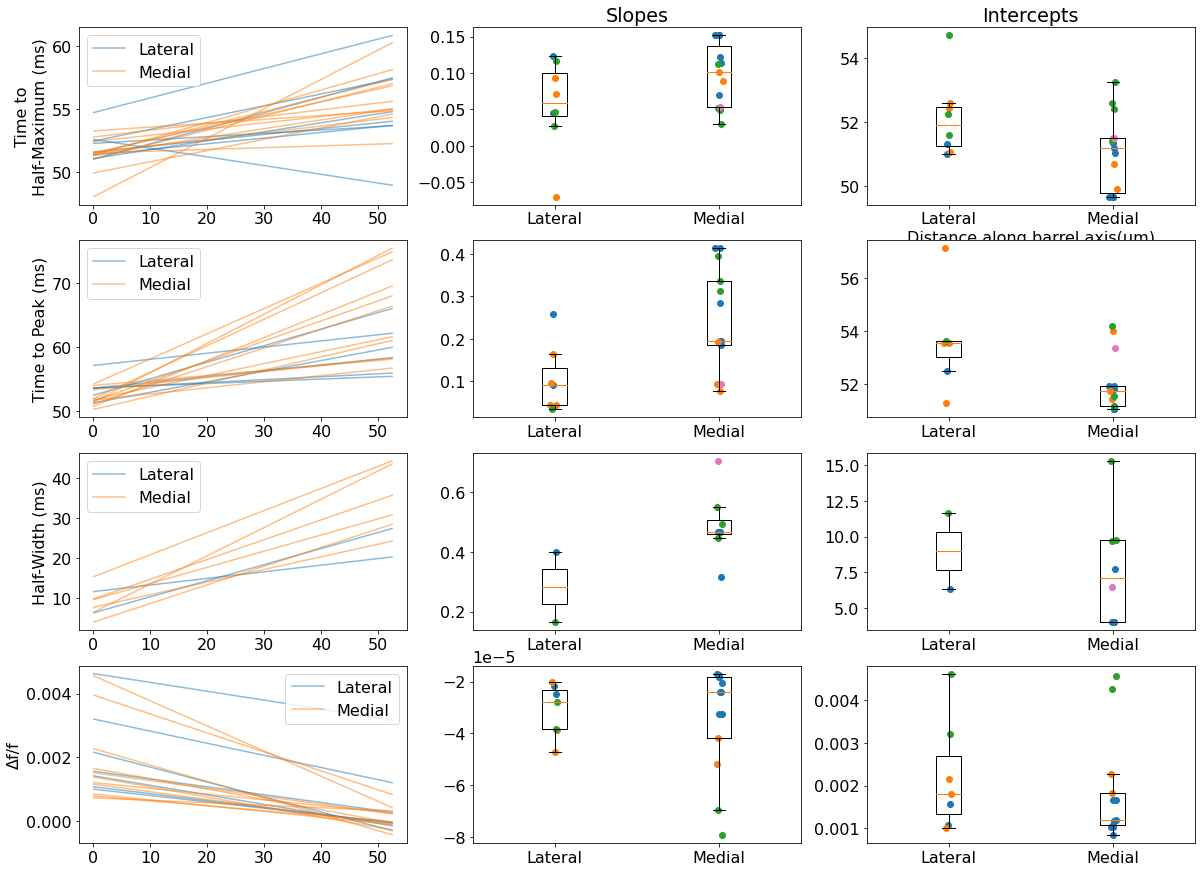

[0.13201510597086874, 0.057969204055241454, 0.006776597083716673, 0.0634779622874515, 0.31111030387243704, 0.7033701126505676, 0.6498962647394759, 0.5372791614452908]
FDR-corrected p-values for slope and intercept of coronal vs sagittal linear regressions: [0.26403021 0.16927457 0.05421278 0.16927457 0.49777649 0.70337011
 0.70337011 0.70337011]
p_val for slope medial_caudal vs lateral_rostral: 0.31117699072217064
p_val for intercept medial_caudal vs lateral_rostral: 0.31345253307650256
p_val for slope medial_caudal vs lateral_rostral: 0.9425083327319648
p_val for intercept medial_caudal vs lateral_rostral: 0.38643920831332046
p_val for slope medial_caudal vs lateral_rostral: 0.04468291461837607
p_val for intercept medial_caudal vs lateral_rostral: 0.2174557254905203
p_val for slope medial_caudal vs lateral_rostral: 0.8857822791669221
p_val for intercept medial_caudal vs lateral_rostral: 0.7408830631686635


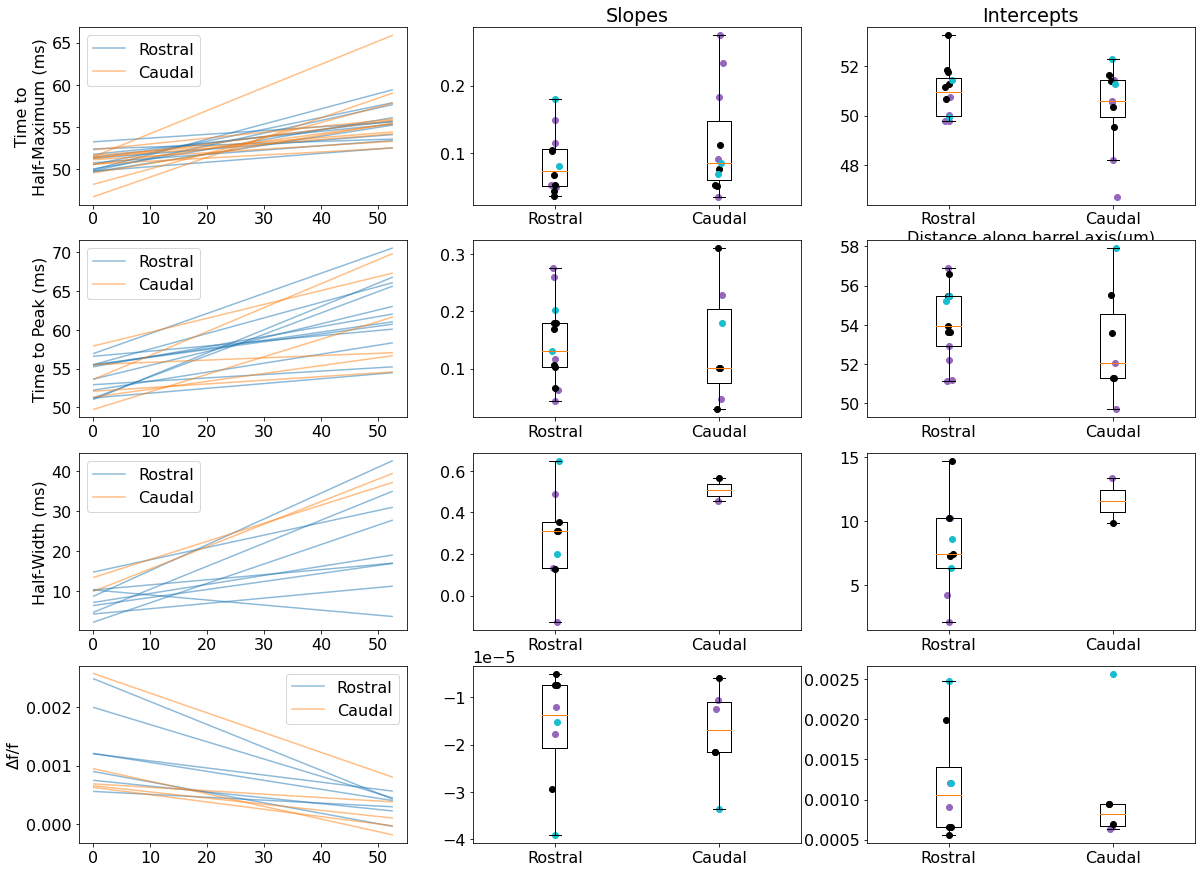

[0.31117699072217064, 0.31345253307650256, 0.9425083327319648, 0.38643920831332046, 0.04468291461837607, 0.2174557254905203, 0.8857822791669221, 0.7408830631686635]
FDR-corrected p-values for slope and intercept of coronal vs sagittal linear regressions: [0.61830273 0.61830273 0.94250833 0.61830273 0.35746332 0.61830273
 0.94250833 0.94250833]


In [281]:
# plot linear regressions for neighbor barrel, medial vs lateral
plt.rcParams.update({'font.size': 16})

for crossing_directions in [["Lateral", "Medial"], ["Rostral", "Caudal"]]:
    predictor = 'Distance_Along_Barrel_Axis'
    barrel = 'neighbor'
    p_vals = []

    fig, ax = plt.subplots(4, 3, figsize=(20, 15))

    for i_plotrow, response_type in enumerate(['Value_lat', 'Max_Amp_Time', 'Value_hw', 'Value']):
        df = merged_df[(merged_df['Value_hw'] > 0) & 
                    (merged_df['Value'] > 0.0001) & (merged_df[predictor] > 0)]
        
        if barrel == 'neighbor':
            df = df[(df['Barrel'] != df['Home_Barrel'])]  # restrict to neighbor barrels
        elif barrel == 'home':
            df = df[(df['Barrel'] == df['Home_Barrel'])]

        df = df[df[response_type] > 0]  # remove any negative values
        linear_regressions = {'medial_caudal': [], 'lateral_rostral': []}
        lin_intercepts = {'medial_caudal': [], 'lateral_rostral': []}
        x_jitter_1 = np.random.normal(0, 0.01, 400)
        x_jitter_2 = np.random.normal(0, 0.01, 400) + 1
        handles = []
        i_jit = 0
        for i, cross_dir in enumerate(crossing_directions):
            df_cd = df[df['Crossing_Direction'] == cross_dir]

            # for each date
            for j, date in enumerate(df_cd['Date'].unique()):
                df_date = df_cd[df_cd['Date'] == date]

                
                for jx, slic_id in enumerate(df_date['Slice'].unique()):
                    df_slic = df_date[(df_date['Slice'] == slic_id)]

                    # for each location, fit a linear regression
                    slice_slopes = []
                    slice_intercepts = []
                    for jxx, loc_id in enumerate(df_slic['Loc'].unique()):
                        df_loc = df_slic[df_slic['Loc'] == loc_id]

                        if len(df_loc) < 3:
                            continue

                        # fit linear regression for latency and distance along barrel axis
                        slope, intercept, r_value, p_value, std_err = linregress(df_loc[predictor], df_loc[response_type])
                        if p_value < 0.075:
                            slice_slopes.append(slope)
                            slice_intercepts.append(intercept)
                            
                            x = np.linspace(min(df[predictor]), max(df[predictor]), 100)
                            y = slope * x + intercept
                            l1 = ax[i_plotrow][0].plot(x, y, alpha=0.5, c=("tab:blue" if cross_dir == crossing_directions[0] else "tab:orange"), 
                                            label=cross_dir)
                            handles.append(l1[0])

                        # plot the mean of the slopes and intercepts for each slice
                        if len(slice_slopes) > 0:
                            if cross_dir == crossing_directions[0]:
                                linear_regressions['medial_caudal'].append(np.mean(slice_slopes))
                                lin_intercepts['medial_caudal'].append(np.mean(slice_intercepts))
                                ax[i_plotrow][1].scatter(x_jitter_1[i_jit], np.mean(slice_slopes), c=color_by_date[date])
                                ax[i_plotrow][2].scatter(x_jitter_1[i_jit], np.mean(slice_intercepts), c=color_by_date[date])
                            else:
                                linear_regressions['lateral_rostral'].append(np.mean(slice_slopes))
                                lin_intercepts['lateral_rostral'].append(np.mean(slice_intercepts))
                                ax[i_plotrow][1].scatter(x_jitter_2[i_jit], np.mean(slice_slopes), c=color_by_date[date])
                                ax[i_plotrow][2].scatter(x_jitter_2[i_jit], np.mean(slice_intercepts), c=color_by_date[date])
                            i_jit += 1

        # add boxplots
        ax[i_plotrow][1].boxplot([linear_regressions['medial_caudal'], linear_regressions['lateral_rostral']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
        ax[i_plotrow][2].boxplot([lin_intercepts['medial_caudal'], lin_intercepts['lateral_rostral']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
        
        # significance tests between medial and lateral (Welch's t-test)
        t_stat, p_val1 = ttest_ind(linear_regressions['medial_caudal'], linear_regressions['lateral_rostral'], alternative='two-sided', equal_var=False)
        print("p_val for slope medial_caudal vs lateral_rostral:", p_val1)
        t_stat, p_val2 = ttest_ind(lin_intercepts['medial_caudal'], lin_intercepts['lateral_rostral'], alternative='two-sided', equal_var=False)
        print("p_val for intercept medial_caudal vs lateral_rostral:", p_val2)

        if p_val1 is not np.nan and 0 < p_val1 < 1:
            p_vals.append(p_val1)
        if p_val2 is not np.nan and 0 < p_val2 < 1:
            p_vals.append(p_val2)

        # add significance lines
        '''if p_val1 < 0.05:
            ax[1].plot([0, 1], [0.5, 0.5], color='black')
            ax[1].annotate("p = " + str(round(p_val1, 2)), (0.4, 0.505), color='black', fontsize=12)

        if p_val2 < 0.05:
            ax[2].plot([0, 1], [55, 55], color='black')
            ax[2].annotate("p = " + str(round(p_val2, 2)), (0.4, 55.1), color='black', fontsize=12)'''
        if len(handles) > 0:
            ax[i_plotrow][0].legend(handles=[handles[0], handles[-1]], labels=crossing_directions)
        for i in range(1,3):
            ax[i_plotrow][i].set_xticks([0, 1])
            ax[i_plotrow][i].set_xticklabels(crossing_directions)
            ax[i_plotrow][i].set_xlim(-0.5, 1.5)

        if predictor == 'Distance_Along_Barrel_Axis' or predictor == 'Distance':
            if response_type == 'Value_lat':
                            
                ax[i_plotrow][0].set_ylabel("Time to\nHalf-Maximum (ms)")

            elif response_type == 'Value_hw':
                ax[i_plotrow][0].set_ylabel("Half-Width (ms)")
            elif response_type == 'Value':
                ax[i_plotrow][0].set_ylabel("Δf/f")
            elif response_type == 'Max_Amp_Time':
                ax[i_plotrow][0].set_ylabel("Time to Peak (ms)")


        elif predictor == 'Value_hw':
            if response_type == 'Value_lat':
                ax[i_plotrow][0].set_xlabel("Half-Width (ms)")
                ax[i_plotrow][0].set_ylabel("Latency (ms)")

            elif response_type == 'Value_hw':
                ax[i_plotrow][0].set_xlabel("Half-Width (ms)")
                ax[i_plotrow][0].set_ylabel("Half-Width (ms)")

        
    ax[0][2].set_xlabel("Distance along barrel axis(um)")
    ax[0][1].set_title("Slopes")
    ax[0][2].set_title("Intercepts")       
    plt.show()

    print(p_vals)
    p_vals = false_discovery_control(p_vals)
    print("FDR-corrected p-values for slope and intercept of coronal vs sagittal linear regressions:", p_vals)      


## 